This notebook runs classification algorithms based on the first 24 hours of a patient's stay. Unlike static_cv.ipynb, this notebook only examines patients with CAM ICU tests, which we interpret to be more reliable than the diagnosis table. This notebook will use mean/common imputation, for RF imputation, see other notebook.

# 1. First model - static

## 1. Import data & libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
modelling_path = "/content/drive/MyDrive/Del_Pred_eICU/24h model/Modelling/"
feature_path = "/content/drive/MyDrive/Del_Pred_eICU/24h model/dataset preparation/Features/"
dataset_path = "/content/drive/MyDrive/Del_Pred_eICU/24h model/dataset preparation/Dataset/"

In [19]:
data = pd.read_csv(modelling_path+"prediction_df_static.csv")
data

,patientunitstayid,Class,apachescore,gender,age,ethnicity,admissionheight,hospitaladmitsource,unittype,unitadmitsource,...,comorb_obes,comorb_wloss,comorb_fed,comorb_blane,comorb_dane,comorb_alcohol,comorb_drug,comorb_psycho,comorb_depre,Anticholinergics
0,242154,1,77.0,Female,46.0,Caucasian,157.48,Direct Admit,Med-Surg ICU,Direct Admit,...,0,0,0,0,0,0,0,0,0,False
1,242290,0,77.0,Female,75.0,Other/Unknown,165.10,Direct Admit,Med-Surg ICU,Direct Admit,...,0,0,0,0,0,0,0,0,0,False
2,242474,0,64.0,Male,52.0,Native American,177.80,NaN,Med-Surg ICU,Emergency Department,...,1,0,1,0,0,1,0,0,0,False
3,242505,1,78.0,Female,90.0,Caucasian,165.10,Emergency Department,Med-Surg ICU,Emergency Department,...,0,0,0,0,0,0,0,0,0,False
4,242714,0,-1.0,Male,78.0,Caucasian,182.90,Direct Admit,Med-Surg ICU,Direct Admit,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23789,3347353,1,74.0,Male,67.0,Caucasian,172.70,Emergency Department,Med-Surg ICU,Emergency Department,...,0,0,0,0,0,0,0,0,0,False
23790,3347960,1,61.0,Female,88.0,Caucasian,170.20,Floor,Med-Surg ICU,Floor,...,0,0,0,0,0,0,0,0,0,False
23791,3349086,1,66.0,Male,68.0,Caucasian,188.00,Direct Admit,Neuro ICU,Direct Admit,...,0,0,0,0,0,0,0,0,0,False
23792,3349342,1,25.0,Male,34.0,African American,167.60,Emergency Department,Neuro ICU,Emergency Department,...,0,0,0,0,0,0,0,0,0,False


#### region - exploration

- West, Midwest, Northeast, South, unknown

In [33]:
# after imputation
# mean imputation made a separate label for the nan rows
print(data.region.value_counts())
print(data.region.value_counts()/data.shape[0])

region
South        15324
Midwest       5722
West          1559
Northeast      530
Name: count, dtype: int64
region
South        0.644028
Midwest      0.240481
West         0.065521
Northeast    0.022275
Name: count, dtype: float64


## 2. Preprocessing

In [34]:
# na counts and ratio
col_with_na = []
for col in data.columns:
    nan_count = pd.isna(data[col]).sum()
    if nan_count != 0:
        print(f"{col}: {nan_count}, ", round(nan_count/data.shape[0], 4), data[col].dtypes)
        col_with_na.append(col)

apachescore: 2764,  0.1162 float64
ethnicity: 120,  0.005 object
admissionheight: 392,  0.0165 float64
hospitaladmitsource: 4027,  0.1692 object
unitadmitsource: 58,  0.0024 object
admissionweight: 498,  0.0209 float64
numbedscategory: 3157,  0.1327 float64
region: 659,  0.0277 object
urgentadmission: 84,  0.0035 float64
Dx_Medical: 84,  0.0035 object
Dx_Neurology/neurosurgery: 84,  0.0035 object
Dx_Surgery: 84,  0.0035 object
Dx_Trauma: 84,  0.0035 object


In [35]:
# dtype setting
Dx_col = ['Dx_Medical', 'Dx_Neurology/neurosurgery', 'Dx_Surgery', 'Dx_Trauma']
data[Dx_col] = data[Dx_col].astype(bool)
data['urgentadmission'] = data['urgentadmission'].astype(bool)
data['numbedscategory'] = data['urgentadmission'].astype(object)
data.loc[:, data.columns.str.startswith("comorb")] = data.loc[:, data.columns.str.startswith("comorb")].astype(bool)

# Convert boolean columns to float
# bool_cols = data.select_dtypes(include=bool).columns
# data[bool_cols] = data[bool_cols].astype(float)

In [36]:
pd.DataFrame(data.dtypes)

,0
patientunitstayid,int64
Class,int64
apachescore,float64
gender,object
age,float64
...,...
comorb_alcohol,bool
comorb_drug,bool
comorb_psycho,bool
comorb_depre,bool


In [37]:
# categorical variables
temp = []
object_col_with_na = []
bool_col_with_na = []
for col in data.columns:
    if (data[col].dtype=='object'):
        print("<"+col+">")
        print(data[col].value_counts())
        print("\n")
        temp.append(col)
        if col in col_with_na:
            object_col_with_na.append(col)
    elif (data[col].dtype=='bool') & (col in col_with_na):
        bool_col_with_na.append(col)
object_col = temp

<gender>
gender
Male       12456
Female     11336
Other          1
Unknown        1
Name: count, dtype: int64


<ethnicity>
ethnicity
Caucasian           16725
African American     4258
Hispanic             1214
Other/Unknown        1051
Asian                 329
Native American        97
Name: count, dtype: int64


<hospitaladmitsource>
hospitaladmitsource
Emergency Department    11776
Floor                    2985
Direct Admit             1508
Operating Room           1093
Recovery Room             971
Other Hospital            658
Acute Care/Floor          479
Step-Down Unit (SDU)      148
Other ICU                  54
PACU                       54
Chest Pain Center          20
ICU                        14
ICU to SDU                  4
Other                       3
Name: count, dtype: int64


<unittype>
unittype
Med-Surg ICU    10755
Cardiac ICU      2979
MICU             2827
Neuro ICU        2563
CCU-CTICU        1894
SICU             1757
CTICU             920
CSICU             

In [38]:
# replace NA value with that has 'Other', 'Unknown' value for gender
data['gender'] = data['gender'].replace(['Other', 'Unknown'], np.nan)

In [39]:
print(col_with_na)
print(object_col_with_na)
print(bool_col_with_na)

['apachescore', 'ethnicity', 'admissionheight', 'hospitaladmitsource', 'unitadmitsource', 'admissionweight', 'numbedscategory', 'region', 'urgentadmission', 'Dx_Medical', 'Dx_Neurology/neurosurgery', 'Dx_Surgery', 'Dx_Trauma']
['ethnicity', 'hospitaladmitsource', 'unitadmitsource', 'numbedscategory', 'region']
['urgentadmission', 'Dx_Medical', 'Dx_Neurology/neurosurgery', 'Dx_Surgery', 'Dx_Trauma']


In [40]:
# column lists generation for the imputation
threshold = 0.2
for col in data.columns:
    missing_count = data[col].isnull().sum()
    total_count = len(data)
    if missing_count > threshold * total_count:
        print(col)
        data.drop(labels=[col], axis=1, inplace=True)

common_imputation= []
common_imputation.extend(object_col_with_na)
common_imputation.extend(bool_col_with_na)


# one_hot_removal = []
# exceptions = []

mean_imputation = []
for col in col_with_na:
  if (col not in object_col_with_na) & (col not in bool_col_with_na) & (col in col_with_na):
    mean_imputation.append(col)


print(mean_imputation)
print(common_imputation)

['apachescore', 'admissionheight', 'admissionweight']
['ethnicity', 'hospitaladmitsource', 'unitadmitsource', 'numbedscategory', 'region', 'urgentadmission', 'Dx_Medical', 'Dx_Neurology/neurosurgery', 'Dx_Surgery', 'Dx_Trauma']


In [41]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(strategy='mean')
data[mean_imputation] = imp_mean.fit_transform(data[mean_imputation])
imp_freq = SimpleImputer(strategy='most_frequent')
data[common_imputation] = imp_freq.fit_transform(data[common_imputation])

# Manual common imputation of UnitAdmit - doesn't work
# data.loc[data["unitadmitsource"] == 1, ["UnitAdmitSource_EmergencyDep"]] == 1
# data[one_hot_removal] = data[one_hot_removal].replace(1, np.NaN)

<Axes: >

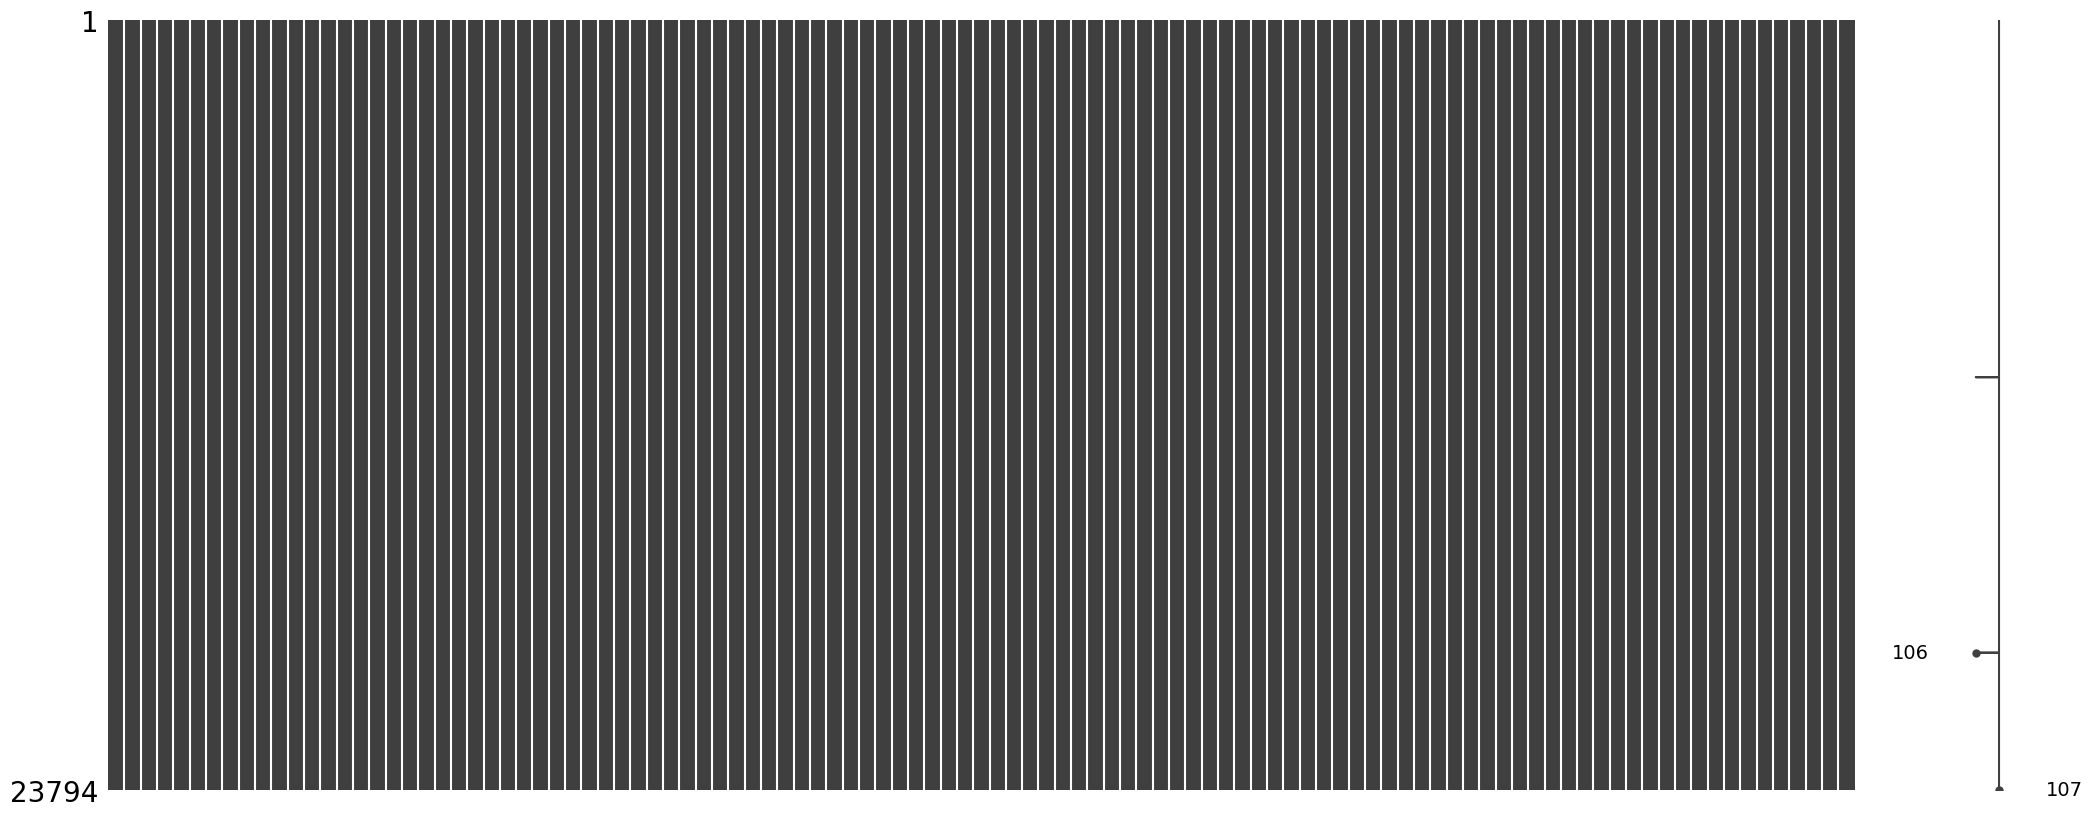

In [42]:
import missingno as msno
msno.matrix(data)

# no more na values

In [43]:
# categorical variables - for dummy coding
object_col.remove('numbedscategory')
object_col

['gender',
 'ethnicity',
 'hospitaladmitsource',
 'unittype',
 'unitadmitsource',
 'unitstaytype',
 'region']

In [44]:
print(data.shape)
dummy_col = [element for element in object_col]
data_subset = data[dummy_col]
data_encoded = pd.get_dummies(data_subset)
data_encoded = pd.concat([data.drop(columns=dummy_col), data_encoded], axis=1)
print(data_encoded.shape)
data_encoded.columns.to_list()

(23794, 107)
(23794, 153)


['patientunitstayid',
 'Class',
 'apachescore',
 'age',
 'admissionheight',
 'unitvisitnumber',
 'admissionweight',
 'numbedscategory',
 'teachingstatus',
 'history_AICD',
 'history_Angina',
 'history_Arrythmia',
 'history_CHF',
 'history_CABG',
 'history_Hypertension',
 'history_MI',
 'history_Pacemaker',
 'history_PVD',
 'history_PCI',
 'history_PulmEmb',
 'history_HeartTransp',
 'history_ValveDis',
 'history_VenThromb',
 'history_Cushing',
 'history_Hypercalcemia',
 'history_hyperthyroid',
 'history_hypothyroid',
 'history_diabetes',
 'history_Steroid Use',
 'history_Cirrhosis',
 'history_Hypersplenism',
 'history_PUD',
 'history_LiverTransp',
 'history_AplasticAnemia',
 'history_Chemotherapy',
 'history_RadiationTherapy',
 'history_Cancer',
 'history_ClottingDisorder',
 'history_HemolyticAnemia',
 'history_HypercoagulableCondition',
 'history_Oncology',
 'history_MyeloproliferativeDisease',
 'history_SickleCellDisease',
 'history_ImmuneSuppr',
 'history_Dementia',
 'history_Intracr

In [45]:
data_encoded.dtypes.value_counts()

bool       140
object       6
float64      4
int64        3
Name: count, dtype: int64

In [46]:
# data_encoded['First24hrComa']=data_encoded['First24hrComa'].astype(int)
# data_encoded['first24hrs_vented']=data_encoded['first24hrs_vented'].astype(int)
# data_encoded['teachingstatus']=data_encoded['teachingstatus'].astype(int)
# data_encoded['urgentadmission']=data_encoded['urgentadmission'].astype(int)

In [47]:
# boolean values into numerical values (0/1)
data_f = data_encoded.astype(float)
data_f.reset_index(inplace=True)
data_f.drop('index', axis=1, inplace=True)

In [48]:
# Extract Labels Before Standardization
labels = data_f['Class']
data_f.drop(['Class'], axis=1, inplace=True)

# Standardize Data
data_standardized = data_f.iloc[:,1:]
scaler = preprocessing.StandardScaler()
data_standardized = scaler.fit_transform(data_standardized)

data_standardized = pd.DataFrame(data_standardized, columns=data_f.columns[1:])
data_standardized

,apachescore,age,admissionheight,unitvisitnumber,admissionweight,numbedscategory,teachingstatus,history_AICD,history_Angina,history_Arrythmia,...,unitadmitsource_Recovery Room,unitadmitsource_Step-Down Unit (SDU),unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer,region_Midwest,region_Northeast,region_South,region_West
0,0.838945,-1.052579,-0.646579,-0.320947,-1.103142,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
1,0.838945,0.666792,-0.203056,-0.320947,-0.376052,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
2,0.301681,-0.696847,0.536151,-0.320947,0.368667,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
3,0.880273,1.556122,-0.203056,-0.320947,-0.789784,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
4,-2.384639,0.844658,0.832997,-0.320947,0.195979,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23789,0.714961,0.192483,0.239304,-0.320947,-0.322087,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792
23790,0.177697,1.437544,0.093791,-0.320947,3.246808,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792
23791,0.384337,0.251771,1.129844,-0.320947,1.167351,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792
23792,-1.310111,-1.764043,-0.057543,-0.320947,-0.314891,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792


In [49]:
processed_data = pd.concat([data_standardized, labels], axis=1)
processed_data

,apachescore,age,admissionheight,unitvisitnumber,admissionweight,numbedscategory,teachingstatus,history_AICD,history_Angina,history_Arrythmia,...,unitadmitsource_Step-Down Unit (SDU),unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer,region_Midwest,region_Northeast,region_South,region_West,Class
0,0.838945,-1.052579,-0.646579,-0.320947,-1.103142,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792,1.0
1,0.838945,0.666792,-0.203056,-0.320947,-0.376052,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792,0.0
2,0.301681,-0.696847,0.536151,-0.320947,0.368667,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792,0.0
3,0.880273,1.556122,-0.203056,-0.320947,-0.789784,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792,1.0
4,-2.384639,0.844658,0.832997,-0.320947,0.195979,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23789,0.714961,0.192483,0.239304,-0.320947,-0.322087,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792,1.0
23790,0.177697,1.437544,0.093791,-0.320947,3.246808,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792,1.0
23791,0.384337,0.251771,1.129844,-0.320947,1.167351,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792,1.0
23792,-1.310111,-1.764043,-0.057543,-0.320947,-0.314891,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792,1.0


In [50]:
# save off the df
processed_data.to_csv(modelling_path+"processed_df_static.csv", index=False)
# check if successfuly saved
processed_data = pd.read_csv(modelling_path+"processed_df_static.csv")
processed_data

,apachescore,age,admissionheight,unitvisitnumber,admissionweight,numbedscategory,teachingstatus,history_AICD,history_Angina,history_Arrythmia,...,unitadmitsource_Step-Down Unit (SDU),unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer,region_Midwest,region_Northeast,region_South,region_West,Class
0,0.838945,-1.052579,-0.646579,-0.320947,-1.103142,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792,1.0
1,0.838945,0.666792,-0.203056,-0.320947,-0.376052,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792,0.0
2,0.301681,-0.696847,0.536151,-0.320947,0.368667,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792,0.0
3,0.880273,1.556122,-0.203056,-0.320947,-0.789784,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792,1.0
4,-2.384639,0.844658,0.832997,-0.320947,0.195979,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23789,0.714961,0.192483,0.239304,-0.320947,-0.322087,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792,1.0
23790,0.177697,1.437544,0.093791,-0.320947,3.246808,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792,1.0
23791,0.384337,0.251771,1.129844,-0.320947,1.167351,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792,1.0
23792,-1.310111,-1.764043,-0.057543,-0.320947,-0.314891,0.337644,-0.708891,0.0,0.0,0.0,...,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792,1.0


## 3. Classification

In [20]:
processed_data = pd.read_csv(modelling_path+"processed_df_static.csv")
labels = processed_data.Class
dataset = processed_data.iloc[:,:-1]
dataset

,apachescore,age,admissionheight,unitvisitnumber,admissionweight,numbedscategory,teachingstatus,history_AICD,history_Angina,history_Arrythmia,...,unitadmitsource_Recovery Room,unitadmitsource_Step-Down Unit (SDU),unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer,region_Midwest,region_Northeast,region_South,region_West
0,0.838945,-1.052579,-0.646579,-0.320947,-1.103142,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
1,0.838945,0.666792,-0.203056,-0.320947,-0.376052,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
2,0.301681,-0.696847,0.536151,-0.320947,0.368667,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
3,0.880273,1.556122,-0.203056,-0.320947,-0.789784,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
4,-2.384639,0.844658,0.832997,-0.320947,0.195979,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23789,0.714961,0.192483,0.239304,-0.320947,-0.322087,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792
23790,0.177697,1.437544,0.093791,-0.320947,3.246808,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792
23791,0.384337,0.251771,1.129844,-0.320947,1.167351,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792
23792,-1.310111,-1.764043,-0.057543,-0.320947,-0.314891,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import t

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, stratify=labels, random_state=42)

In [22]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19035, 151) (19035,)
(4759, 151) (4759,)


In [25]:
# stratified split - label outcome variable distribution
print(y_train.value_counts()/y_train.shape[0])
print('\n')
print(y_test.value_counts()/y_test.shape[0])

Class
0.0    0.783609
1.0    0.216391
Name: count, dtype: float64


Class
0.0    0.783568
1.0    0.216432
Name: count, dtype: float64


In [57]:
X_train

,apachescore,age,admissionheight,unitvisitnumber,admissionweight,numbedscategory,teachingstatus,history_AICD,history_Angina,history_Arrythmia,...,unitadmitsource_Recovery Room,unitadmitsource_Step-Down Unit (SDU),unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer,region_Midwest,region_Northeast,region_South,region_West
11240,-3.182393e-01,-0.400404,-0.034260,-0.320947,9.083186e-01,0.337644,-0.708891,0.0,0.0,0.0,...,4.33726,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792
12133,3.016806e-01,0.726080,-0.325287,-0.320947,-6.386820e-01,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792
17717,-5.248793e-01,-0.696847,0.547792,-0.320947,2.499439e-01,0.337644,1.410655,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,1.777171,-0.150937,-1.430460,-0.264792
5348,1.913473e+00,-2.179064,0.722407,1.734669,3.495047e+00,0.337644,1.410655,0.0,0.0,0.0,...,-0.23056,-0.147404,-2.392753,-0.233577,-0.235969,4.649502,-0.562692,-0.150937,0.699076,-0.264792
20459,2.936531e-16,0.429637,-0.203056,-0.320947,-4.659936e-01,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,-1.430460,3.776552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10068,2.368081e+00,-0.637559,0.838818,-0.320947,-2.933051e-01,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792
7805,-6.901913e-01,0.073905,-1.722212,1.734669,7.248371e-01,-2.961699,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,-2.392753,4.281238,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792
5570,2.190246e-01,1.437544,0.373176,1.734669,5.845278e-01,0.337644,1.410655,0.0,0.0,0.0,...,-0.23056,-0.147404,-2.392753,-0.233577,-0.235969,4.649502,-0.562692,-0.150937,0.699076,-0.264792
18337,-1.103471e+00,-0.637559,0.000000,-0.320947,5.112605e-16,0.337644,-0.708891,0.0,0.0,0.0,...,-0.23056,-0.147404,0.417929,-0.233577,-0.235969,-0.215077,-0.562692,-0.150937,0.699076,-0.264792


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import t
from sklearn.metrics import confusion_matrix


def train_and_evaluate(X_train, y_train, clf, cv):
    precision_scores = []
    recall_scores = []
    roc_auc_scores = []
    brier_scores = []
    specificity_list = []
    sensitivity_list = []
    npv_list = []
    ppv_list = []
    precision_list = []
    recall_list = []
    fpr_list = []  # List to store false positive rates
    tpr_list = []  # List to store true positive rates

    for train_index, val_index in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        clf.fit(X_train_fold, y_train_fold)
        y_pred_proba = clf.predict_proba(X_val_fold)[:, 1]

        precision, recall, _ = precision_recall_curve(y_val_fold, y_pred_proba)
        precision_scores.append(precision)
        recall_scores.append(recall)

        roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred_proba))
        brier_scores.append(brier_score_loss(y_val_fold, y_pred_proba))

        y_pred = clf.predict(X_val_fold)

        tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred).ravel()

        precision = precision_score(y_val_fold, y_pred)
        precision_list.append(precision)
        recall = recall_score(y_val_fold, y_pred)
        recall_list.append(recall)

        specificity = tn / (tn + fp)
        specificity_list.append(specificity)

        sensitivity = tp / (tp + fn)
        sensitivity_list.append(sensitivity)

        npv = tn / (tn + fn)
        npv_list.append(npv)

        ppv = tp / (tp + fp)
        ppv_list.append(ppv)

        # Calculate fpr and tpr
        fpr, tpr, _ = roc_curve(y_val_fold, y_pred_proba)
        fpr_list.append(fpr)
        tpr_list.append(tpr)

    return precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list

def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    t_value = t.ppf((1 + confidence) / 2, n - 1)
    margin_of_error = t_value * std_err
    return mean, margin_of_error

def plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc'):
    plt.figure()
    if curve_type == 'precision_recall':
        for i in range(len(precision_scores)):
            plt.plot(recall_scores[i], precision_scores[i], lw=1, alpha=0.3, label='Fold %d' % i)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="best")
    elif curve_type == 'roc':
        for i in range(len(fpr_list)):
            plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='Fold %d' % i)

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
    plt.show()


def print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list):
    mean_roc_auc, roc_auc_ci = calculate_confidence_interval(roc_auc_scores)
    mean_brier_score, brier_score_ci = calculate_confidence_interval(brier_scores)
    specificity_mean, specificity_ci = calculate_confidence_interval(specificity_list)
    sensitivity_mean, sensitivity_ci = calculate_confidence_interval(sensitivity_list)
    npv_mean, npv_ci = calculate_confidence_interval(npv_list)
    ppv_mean, ppv_ci = calculate_confidence_interval(ppv_list)
    precision_mean, precision_ci = calculate_confidence_interval(precision_list)
    recall_mean, recall_ci = calculate_confidence_interval(recall_list)

    print("ROC AUC Score:", round(mean_roc_auc,3), (round((mean_roc_auc - roc_auc_ci),3), round((mean_roc_auc + roc_auc_ci),3)))
    print("Brier Score:", round(mean_brier_score,3), (round((mean_brier_score - brier_score_ci),3), round((mean_brier_score + brier_score_ci),3)))
    print("Specificity: {:.3f} ({:.3f}, {:.3f})".format(specificity_mean, specificity_mean - specificity_ci, specificity_mean + specificity_ci))
    print("Sensitivity: {:.3f} ({:.3f}, {:.3f})".format(sensitivity_mean, sensitivity_mean - sensitivity_ci, sensitivity_mean + sensitivity_ci))
    print("Negative Pred Value (NPV): {:.3f} ({:.3f}, {:.3f})".format(npv_mean, npv_mean - npv_ci, npv_mean + npv_ci))
    print("Positive Pred Value (PPV): {:.3f} ({:.3f}, {:.3f})".format(ppv_mean, ppv_mean - ppv_ci, ppv_mean + ppv_ci))
    print("Precision: {:.3f} ({:.3f}, {:.3f})".format(precision_mean, precision_mean - specificity_ci, precision_mean + precision_ci))
    print("Recall: {:.3f} ({:.3f}, {:.3f})".format(recall_mean, recall_mean - sensitivity_ci, recall_mean + recall_ci))


def evaluate_test_set(clf, X_test, y_test):
    y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
    y_pred_test = clf.predict(X_test)

    recall_test = recall_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
    brier_score_test = brier_score_loss(y_test, y_pred_proba_test)

    print("Test Set Metrics:")
    print("ROC AUC Score:", round(roc_auc_test, 3))
    print("Recall (Sensitivity):", round(recall_test, 3))
    print("Brier Score:", round(brier_score_test, 3))

### Random Forest

ROC AUC Score: 0.748 (0.743, 0.753)
Brier Score: 0.145 (0.143, 0.146)
Specificity: 0.966 (0.958, 0.974)
Sensitivity: 0.193 (0.174, 0.212)
Negative Predictive Value (NPV): 0.813 (0.808, 0.817)
Positive Predictive Value (PPV): 0.612 (0.535, 0.690)
Precision: 0.612 (0.605, 0.690)
Recall: 0.193 (0.174, 0.212)


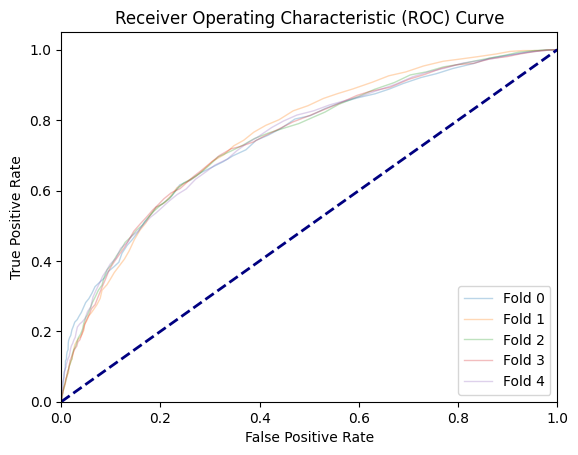

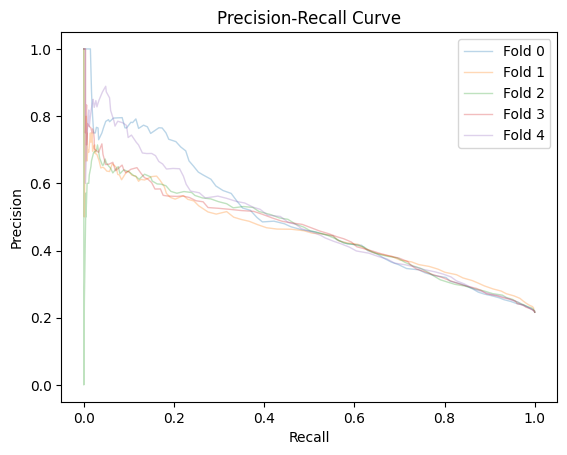

In [59]:
# Initializing the classifier
clf = RandomForestClassifier()

# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train, y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

In [60]:
evaluate_test_set(clf, X_test, y_test)

Test Set Metrics:
ROC AUC Score: 0.746
Recall (Sensitivity): 0.187
Brier Score: 0.146



### Logistic Regression

ROC AUC Score: 0.745 (0.737, 0.753)
Brier Score: 0.146 (0.144, 0.149)
Specificity: 0.962 (0.958, 0.967)
Sensitivity: 0.192 (0.183, 0.202)
Negative Predictive Value (NPV): 0.812 (0.810, 0.814)
Positive Predictive Value (PPV): 0.585 (0.555, 0.616)
Precision: 0.585 (0.581, 0.616)
Recall: 0.192 (0.183, 0.202)


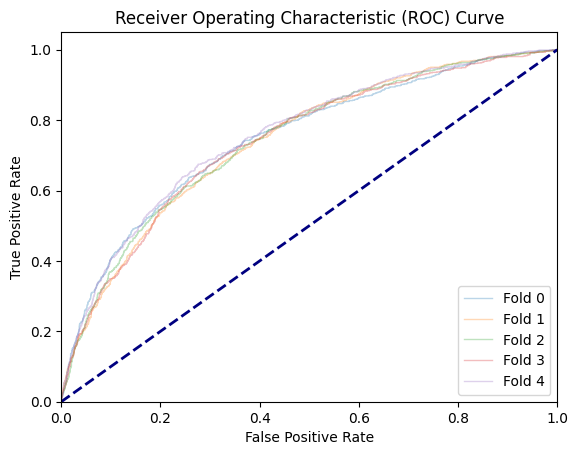

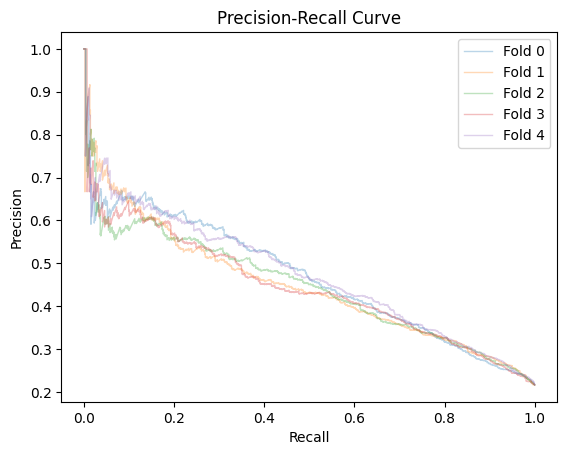

In [62]:
from sklearn.linear_model import LogisticRegression

# Initializing the classifier
clf = LogisticRegression()

# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train, y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

In [63]:
evaluate_test_set(clf, X_test, y_test)

Test Set Metrics:
ROC AUC Score: 0.741
Recall (Sensitivity): 0.177
Brier Score: 0.148


### Catboost

In [64]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.0 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
12:	learn: 0.5559631	total: 192ms	remaining: 14.6s
13:	learn: 0.5494043	total: 201ms	remaining: 14.1s
14:	learn: 0.5436266	total: 208ms	remaining: 13.7s
15:	learn: 0.5376383	total: 216ms	remaining: 13.3s
16:	learn: 0.5319858	total: 224ms	remaining: 12.9s
17:	learn: 0.5268139	total: 231ms	remaining: 12.6s
18:	learn: 0.5223709	total: 239ms	remaining: 12.4s
19:	learn: 0.5183617	total: 247ms	remaining: 12.1s
20:	learn: 0.5143765	total: 256ms	remaining: 11.9s
21:	learn: 0.5100506	total: 264ms	remaining: 11.7s
22:	learn: 0.5064350	total: 272ms	remaining: 11.6s
23:	learn: 0.5030537	total: 280ms	remaining: 11.4s
24:	learn: 0.5002211	total: 287ms	remaining: 11.2s
25:	learn: 0.4976425	total: 295ms	remaining: 11s
26:	learn: 0.4946188	total: 303ms	remaining: 10.9s
27:	learn: 0.4923578	total: 311ms	remaining: 10.8s
28:	learn: 0.4898962	total: 319ms	remaining: 10.7s
29:	learn: 0.4875346	total: 327ms	remaining: 10.6s
30:	learn: 0.4850751	total: 334ms

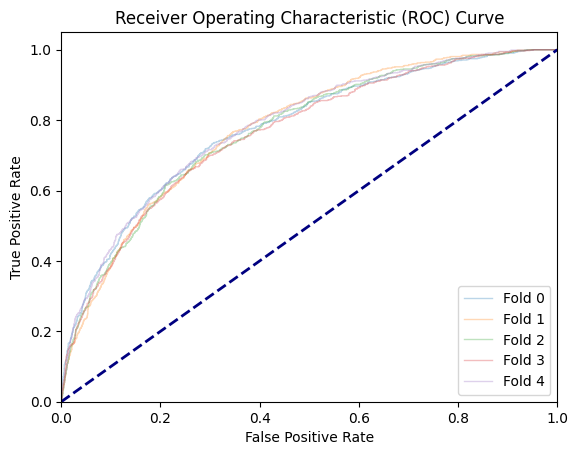

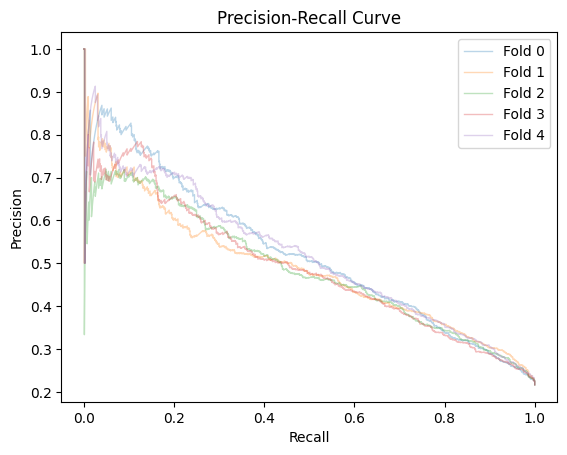

In [65]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier()

# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train, y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

In [66]:
evaluate_test_set(clf, X_test, y_test)

Test Set Metrics:
ROC AUC Score: 0.766
Recall (Sensitivity): 0.234
Brier Score: 0.143


### XGBoost

In [28]:
pip install xgboost

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x79bd12df98a0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 641, in _next_wrapper
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 557, in _handle_exception
    return fn()
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 1280, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 633, in input_data
    self.proxy.set_info(
  File "/usr/local/lib/python3.1

ROC AUC Score: 0.751 (0.743, 0.76)
Brier Score: 0.147 (0.145, 0.149)
Specificity: 0.935 (0.929, 0.942)
Sensitivity: 0.283 (0.263, 0.303)
Negative Pred Value (NPV): 0.825 (0.821, 0.829)
Positive Pred Value (PPV): 0.548 (0.518, 0.577)
Precision: 0.548 (0.541, 0.577)
Recall: 0.283 (0.263, 0.303)


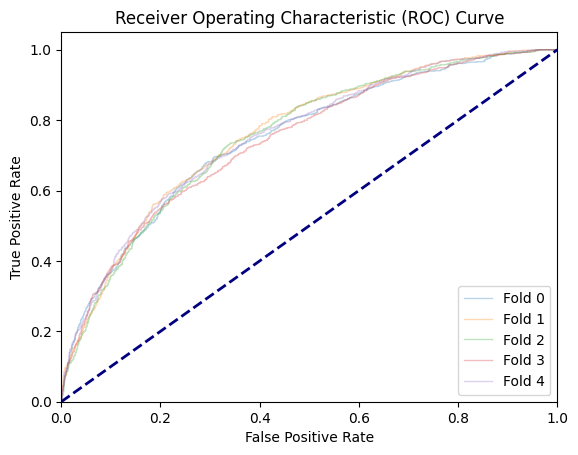

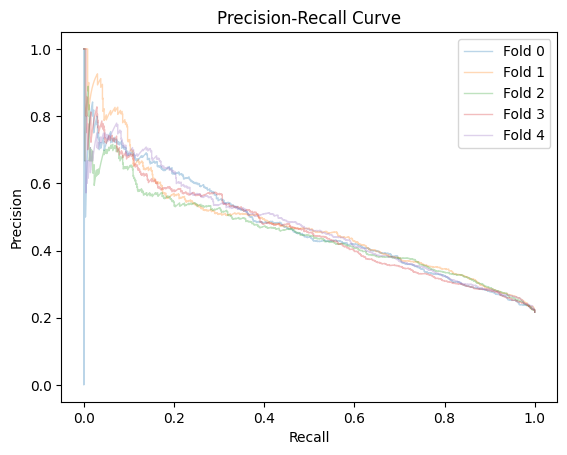

Test Set Metrics:
ROC AUC Score: 0.745
Recall (Sensitivity): 0.283
Brier Score: 0.15


In [38]:
# Initializing the classifier
from xgboost import XGBClassifier
clf = XGBClassifier()

# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train, y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

evaluate_test_set(clf, X_test, y_test)

#### XGBoost + decision boundary tuning

In [56]:
# Confusion matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    title_first_line = title
    tp_fn_sum = np.sum(np.diag(cm)) + np.sum(cm[:, -1])
    title_second_line = f"TP+FN: {tp_fn_sum}"
    title_fontsize_first_line = 12
    title_fontsize_second_line = 8

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title_first_line + '\n' + title_second_line, fontsize=title_fontsize_first_line)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Calculate and print sum of TP and FN
    # tp_fn_sum = np.sum(np.diag(cm)) + np.sum(cm[:, -1])
    # plt.text(-0.5, -0.5, f"TP+FN: {tp_fn_sum}", horizontalalignment="left", verticalalignment="center", color="red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Decision boundary Tuning
thresholds = [0.35,0.38,0.41,0.44,0.47,0.50,0.53,0.56,0.59]
def decision_bnd_tuning(model, thresholds, X_valid, y_valid):
  y_pred_proba = model.predict_proba(X_valid)

  plt.figure(figsize=(10,10))
  j = 1
  for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] > i

    plt.subplot(3,3,j)
    j += 1
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_valid,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    Recall = round(cnf_matrix[1,1] / (cnf_matrix[1,1] + cnf_matrix[1,0]),4)
    Precision = round(cnf_matrix[1,1] / (cnf_matrix[1,1] + cnf_matrix[0,1]),4)
    Accuracy = round((cnf_matrix[1,1] + cnf_matrix[0,0]) / (cnf_matrix[1,1] + cnf_matrix[1,0] + cnf_matrix[0,1] + cnf_matrix[0,0]),4)
    F1 = round((2*Recall*Precision/(Recall+Precision)),4)
    print("<threshold ",i,">")
    print("Accuracy: ", Accuracy, "| F1: ", F1, "| Recall: ", Recall, "| Precision: ", Precision)

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i)


<threshold  0.35 >
Accuracy:  0.8783 | F1:  0.7131 | Recall:  0.6987 | Precision:  0.7281
<threshold  0.38 >
Accuracy:  0.8808 | F1:  0.7046 | Recall:  0.657 | Precision:  0.7597
<threshold  0.41 >
Accuracy:  0.8805 | F1:  0.6896 | Recall:  0.6135 | Precision:  0.7872
<threshold  0.44 >
Accuracy:  0.8795 | F1:  0.6727 | Recall:  0.5722 | Precision:  0.8159
<threshold  0.47 >
Accuracy:  0.877 | F1:  0.6539 | Recall:  0.5368 | Precision:  0.8362
<threshold  0.5 >
Accuracy:  0.8733 | F1:  0.6308 | Recall:  0.4999 | Precision:  0.8544
<threshold  0.53 >
Accuracy:  0.8703 | F1:  0.6097 | Recall:  0.4681 | Precision:  0.874
<threshold  0.56 >
Accuracy:  0.8656 | F1:  0.5814 | Recall:  0.4314 | Precision:  0.8912
<threshold  0.59 >
Accuracy:  0.8606 | F1:  0.5499 | Recall:  0.3935 | Precision:  0.9127


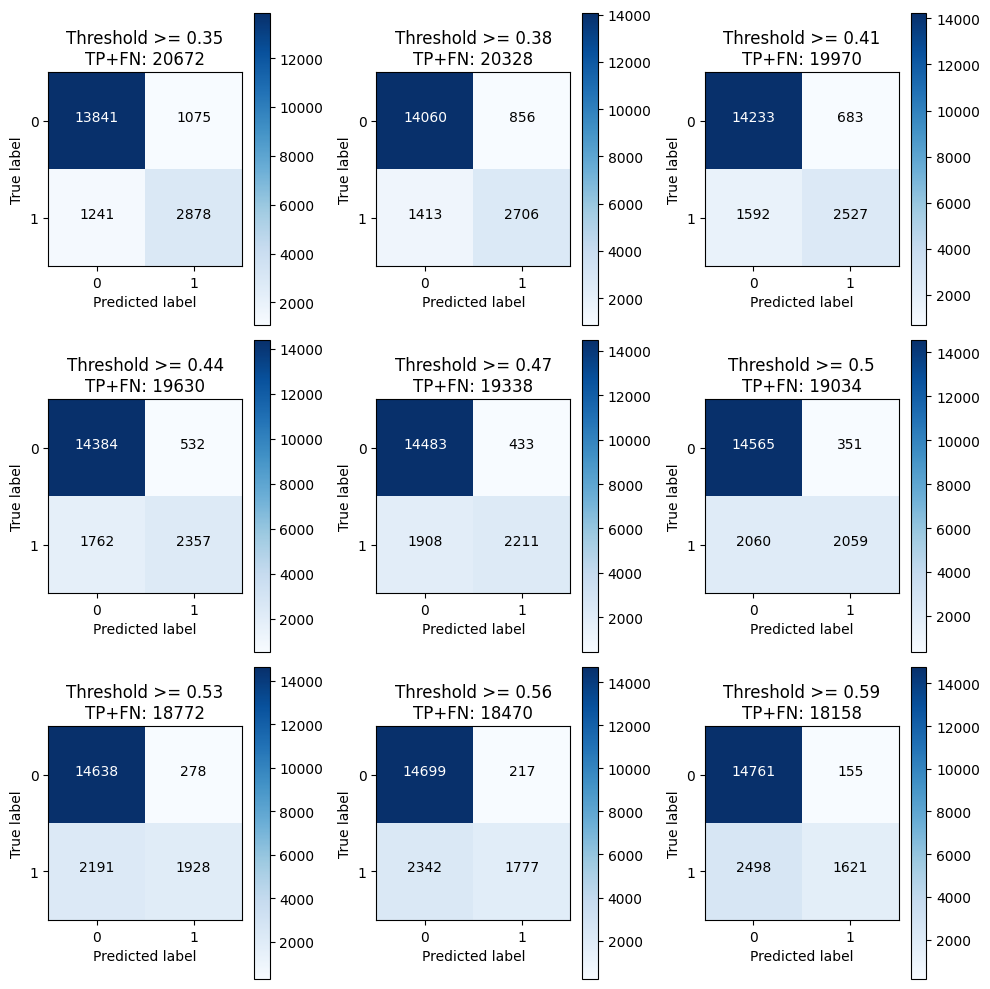

In [57]:
# train set
decision_bnd_tuning(clf, thresholds, X_train, y_train)

<threshold  0.35 >
Accuracy:  0.7649 | F1:  0.4485 | Recall:  0.4417 | Precision:  0.4555
<threshold  0.38 >
Accuracy:  0.7722 | F1:  0.4318 | Recall:  0.4 | Precision:  0.4692
<threshold  0.41 >
Accuracy:  0.7737 | F1:  0.404 | Recall:  0.3544 | Precision:  0.4698
<threshold  0.44 >
Accuracy:  0.7823 | F1:  0.3977 | Recall:  0.332 | Precision:  0.4957
<threshold  0.47 >
Accuracy:  0.7901 | F1:  0.3883 | Recall:  0.3078 | Precision:  0.5257
<threshold  0.5 >
Accuracy:  0.7943 | F1:  0.3728 | Recall:  0.2825 | Precision:  0.548
<threshold  0.53 >
Accuracy:  0.7972 | F1:  0.3484 | Recall:  0.2505 | Precision:  0.5721
<threshold  0.56 >
Accuracy:  0.7976 | F1:  0.3289 | Recall:  0.2291 | Precision:  0.5827
<threshold  0.59 >
Accuracy:  0.7972 | F1:  0.2972 | Recall:  0.1981 | Precision:  0.5948


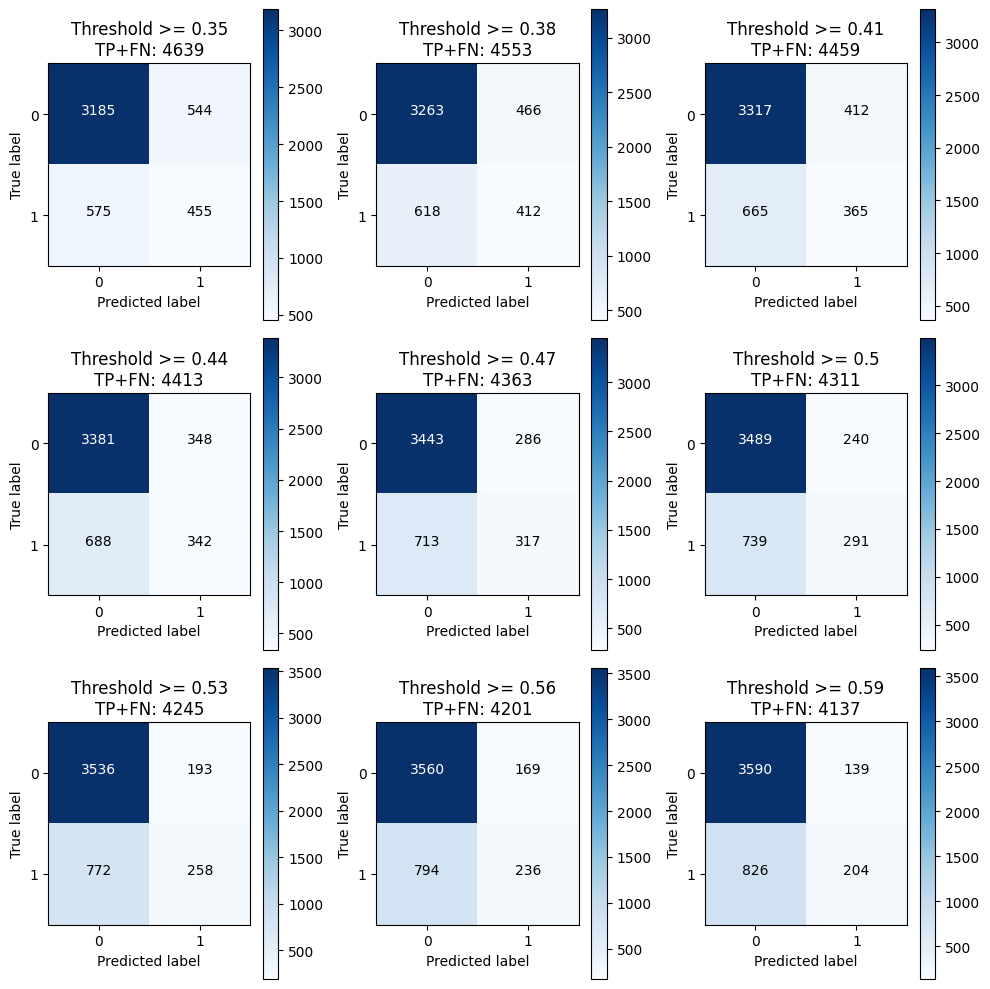

In [58]:
# validation set
decision_bnd_tuning(clf, thresholds, X_test, y_test)

#### XGBoost + hyperparameter tuning

In [61]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()
grid = {'max_depth': [6,7,8],'n_estimators':[150,200,250],'learning_rate':[0.2, 0.25, 0.3]}

#Instantiate GridSearchCV
gscv = GridSearchCV (estimator = xgb, param_grid = grid, scoring ='recall_macro', cv = 4)

#fit the model
gscv.fit(X_train, y_train)

#returns the estimator with the best performance
print(gscv.best_estimator_)

#returns the best score
print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.6112312584314045
{'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 200}


- varied the parameters with other values many times

ROC AUC Score: 0.751 (0.743, 0.76)
Brier Score: 0.147 (0.145, 0.149)
Specificity: 0.935 (0.929, 0.942)
Sensitivity: 0.283 (0.263, 0.303)
Negative Pred Value (NPV): 0.825 (0.821, 0.829)
Positive Pred Value (PPV): 0.548 (0.518, 0.577)
Precision: 0.548 (0.541, 0.577)
Recall: 0.283 (0.263, 0.303)


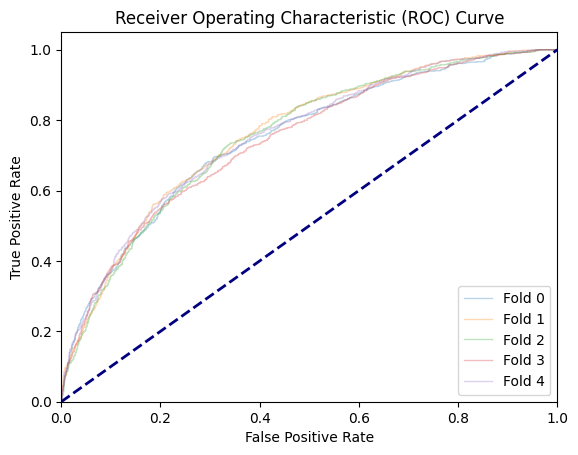

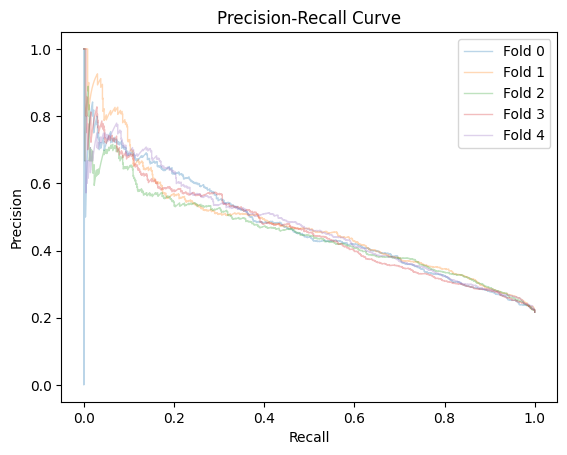

Test Set Metrics:
ROC AUC Score: 0.745
Recall (Sensitivity): 0.283
Brier Score: 0.15


In [62]:
params = {'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 200}

xgb_tuned = XGBClassifier(**params)

# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train, y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

evaluate_test_set(clf, X_test, y_test)

- the train/validation set performance is same

<threshold  0.35 >
Accuracy:  0.7626 | F1:  0.4411 | Recall:  0.433 | Precision:  0.4496
<threshold  0.38 >
Accuracy:  0.7674 | F1:  0.4225 | Recall:  0.3932 | Precision:  0.4566
<threshold  0.41 >
Accuracy:  0.7737 | F1:  0.4067 | Recall:  0.3583 | Precision:  0.4701
<threshold  0.44 >
Accuracy:  0.7808 | F1:  0.3918 | Recall:  0.3262 | Precision:  0.4905
<threshold  0.47 >
Accuracy:  0.7886 | F1:  0.3844 | Recall:  0.3049 | Precision:  0.5199
<threshold  0.5 >
Accuracy:  0.7926 | F1:  0.3661 | Recall:  0.2767 | Precision:  0.5408
<threshold  0.53 >
Accuracy:  0.7924 | F1:  0.3413 | Recall:  0.2485 | Precision:  0.5447
<threshold  0.56 >
Accuracy:  0.7947 | F1:  0.3144 | Recall:  0.2175 | Precision:  0.5671
<threshold  0.59 >
Accuracy:  0.7976 | F1:  0.2935 | Recall:  0.1942 | Precision:  0.6006


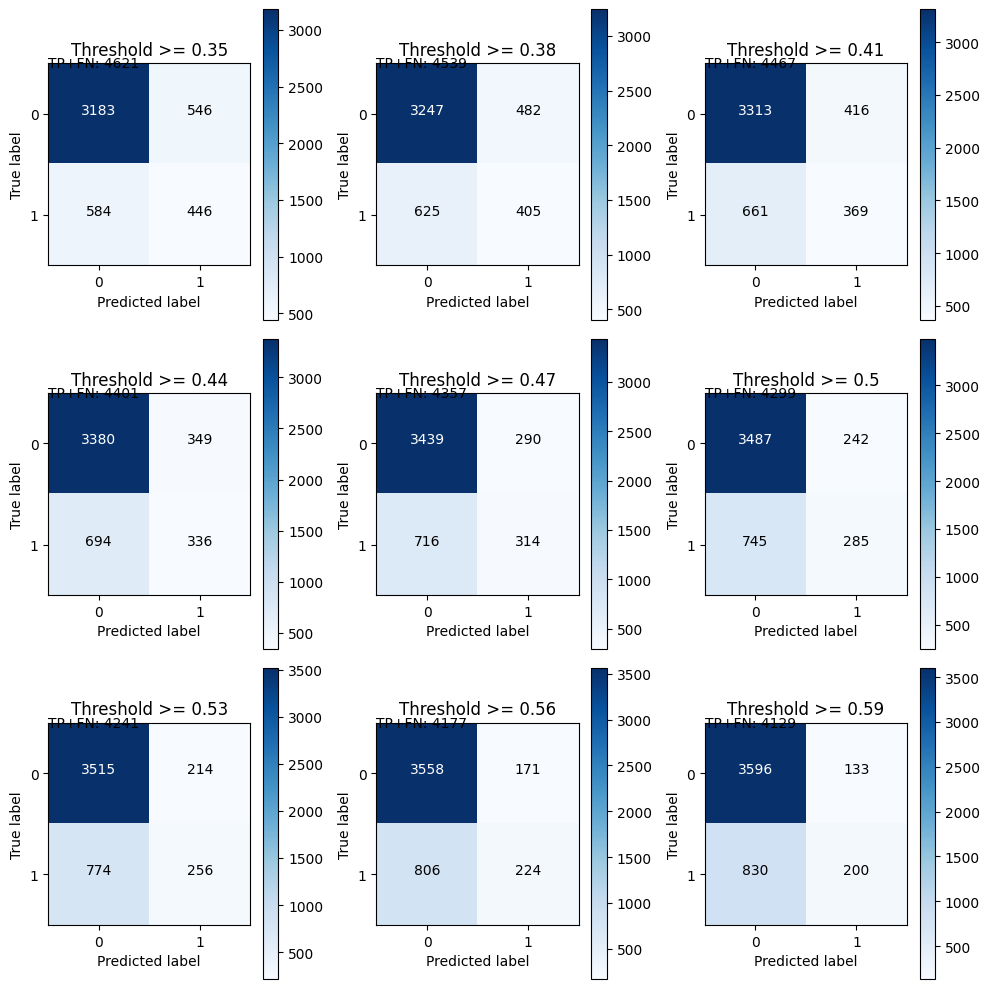

In [133]:
decision_bnd_tuning(clf, thresholds, X_test, y_test)

### (+a) Feature Selection

In [64]:
import seaborn as sns

def get_importances (model, X_train, y_train):
  model.fit(X_train, y_train)
  ftr_importances = model.feature_importances_
  ftr_importances = pd.Series(ftr_importances, index = X_train.columns)
  ftr_imp = ftr_importances.sort_values(ascending=False)[:70]

  plt.figure(figsize=(10,20))
  plt.title('Feature Importances')
  sns.barplot(x=ftr_imp, y=ftr_imp.index)
  plt.show()

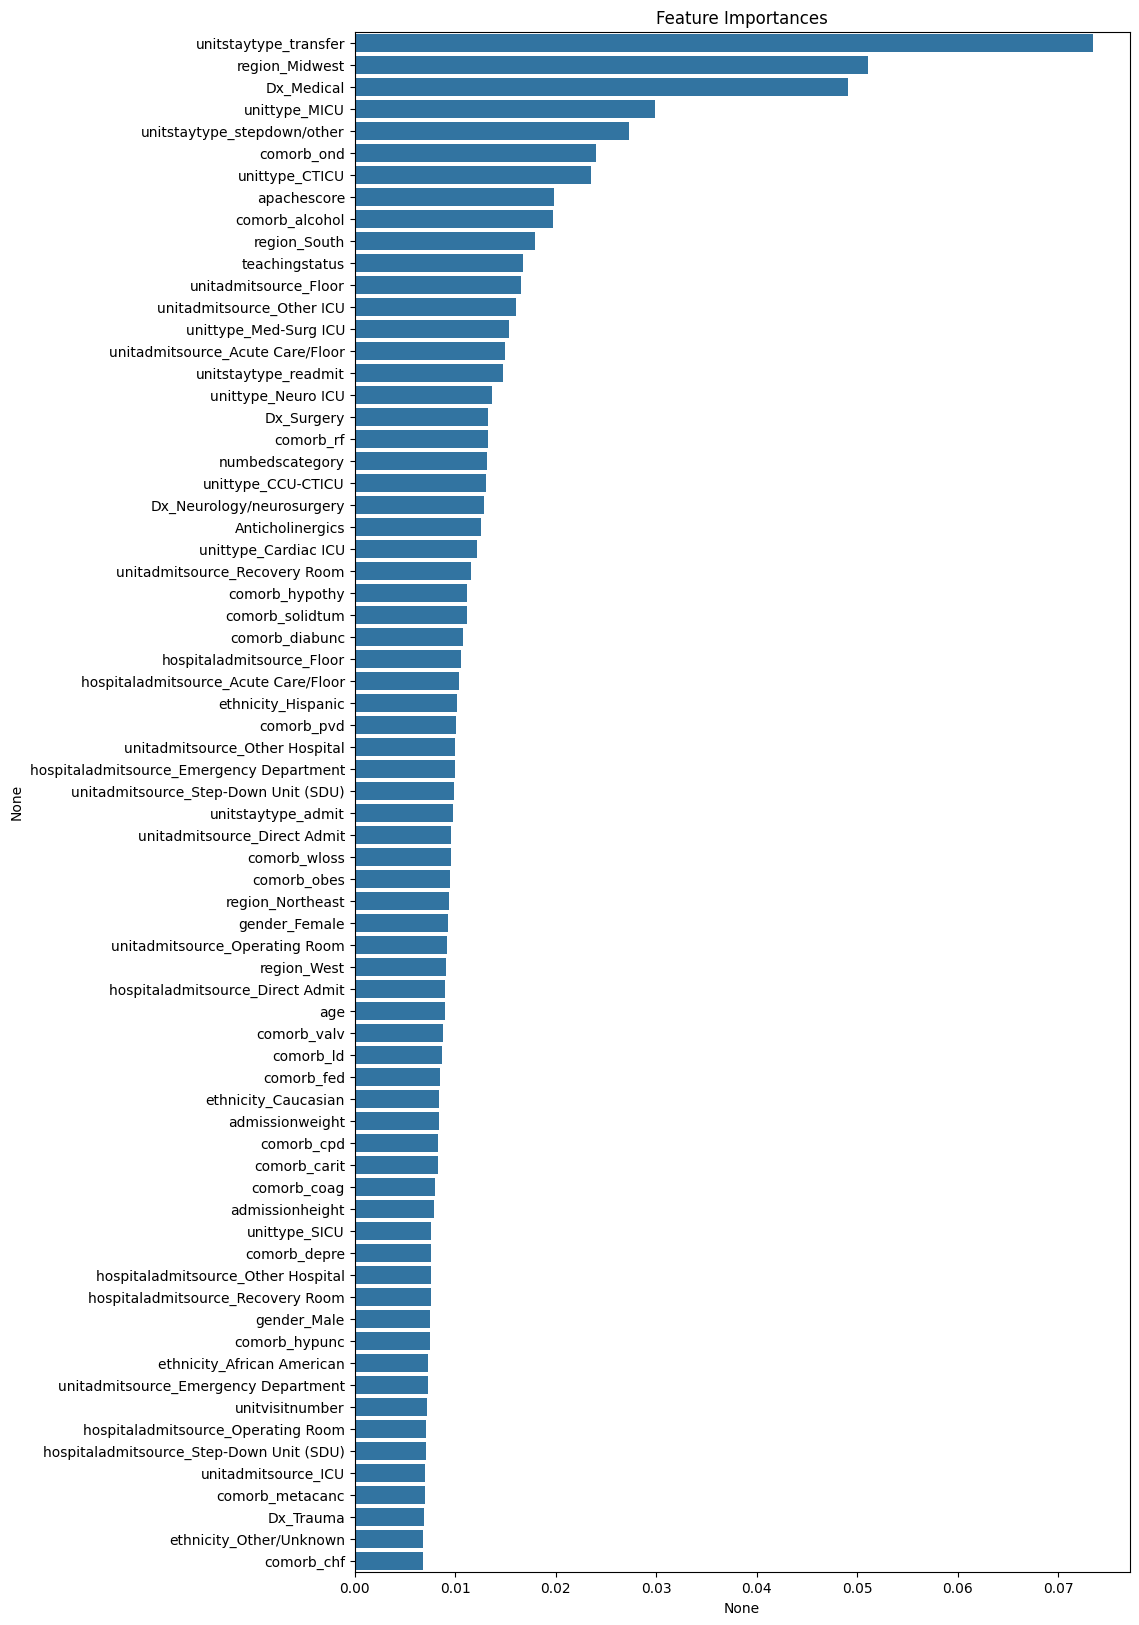

In [65]:
get_importances(clf, X_train, y_train)

In [ ]:
ftr_importances = xgb_tuned.feature_importances_
ftr_importances = pd.Series(ftr_importances, index = X_train.columns)
ftr_imp = ftr_importances.sort_values(ascending=False)
feature_selection = ftr_imp[ftr_imp>0].index.to_list()

ROC AUC Score: 0.771 (0.764, 0.778)
Brier Score: 0.142 (0.14, 0.144)
Specificity: 0.936 (0.932, 0.940)
Sensitivity: 0.325 (0.316, 0.334)
Negative Predictive Value (NPV): 0.834 (0.832, 0.835)
Positive Predictive Value (PPV): 0.583 (0.571, 0.594)
Precision: 0.583 (0.579, 0.594)
Recall: 0.325 (0.316, 0.334)


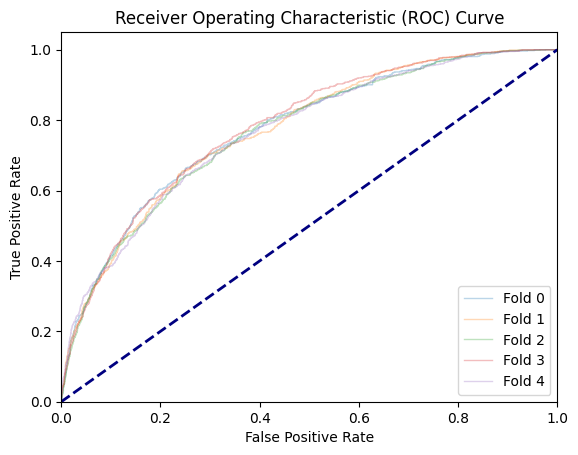

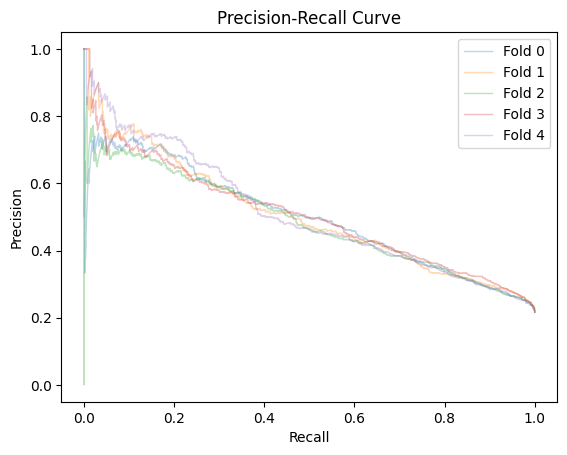

Test Set Metrics:
ROC AUC Score: 0.77
Recall (Sensitivity): 0.318
Brier Score: 0.146


In [ ]:
# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation only with selected columns
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train[feature_selection], y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

evaluate_test_set(clf, X_test[feature_selection], y_test)

- doesn't show the improvement

# 2. Second model - dynamic

## 1. Import data & libraries

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
modelling_path = "/content/drive/MyDrive/Del_Pred_eICU/24h model/Modelling/"
feature_path = "/content/drive/MyDrive/Del_Pred_eICU/24h model/dataset preparation/Features/"
dataset_path = "/content/drive/MyDrive/Del_Pred_eICU/24h model/dataset preparation/Dataset/"

In [68]:
data = pd.read_csv(modelling_path+"prediction_df_dynamic.csv")
data

<ipython-input-68-bf8205c62db0>:1: DtypeWarning: Columns (71,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(modelling_path+"prediction_df_dynamic.csv")


,patientunitstayid,Class,apachescore,gender,age,ethnicity,admissionheight,hospitaladmitsource,unittype,unitadmitsource,...,24hrMed_ColloidFluids,24hrMed_SSRIAntidepressants,24hrMed_MiscAntidepressants,24hrMed_Methylxanthines,24hrMed_NSAIDs,24hrMed_PhenylpiperazineAntidepressants,24hrMed_Somatostatin,24hrMed_ProtonPumpInhibitor,24hrMed_AdrenergicBronchodilators,24hrMed_GeneralAnesthetics
0,242154,1,77.0,Female,46.0,Caucasian,157.48,Direct Admit,Med-Surg ICU,Direct Admit,...,False,True,True,False,False,True,True,False,True,True
1,242505,1,78.0,Female,90.0,Caucasian,165.10,Emergency Department,Med-Surg ICU,Emergency Department,...,False,True,False,False,False,True,True,True,True,False
2,242714,0,-1.0,Male,78.0,Caucasian,182.90,Direct Admit,Med-Surg ICU,Direct Admit,...,False,True,False,False,False,True,True,False,False,False
3,243493,0,34.0,Male,73.0,Caucasian,172.72,Emergency Department,Med-Surg ICU,Emergency Department,...,False,True,False,False,False,True,True,False,False,False
4,243494,0,147.0,Female,73.0,Caucasian,165.10,Direct Admit,Med-Surg ICU,Direct Admit,...,False,True,True,False,False,True,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,3336610,1,56.0,Male,66.0,Caucasian,175.30,Emergency Department,Med-Surg ICU,Emergency Department,...,False,True,False,False,False,True,True,False,False,False
14719,3340732,1,47.0,Male,51.0,Caucasian,170.00,NaN,Neuro ICU,Operating Room,...,False,True,False,False,False,True,True,False,False,False
14720,3341272,1,79.0,Female,63.0,African American,149.90,Emergency Department,Med-Surg ICU,Emergency Department,...,False,True,False,False,False,True,True,True,True,False
14721,3349342,1,25.0,Male,34.0,African American,167.60,Emergency Department,Neuro ICU,Emergency Department,...,False,True,False,False,False,True,True,True,False,False


## 2. Preprocessing

In [69]:
# na counts and ratio
col_with_na = []
for col in data.columns:
    nan_count = pd.isna(data[col]).sum()
    if nan_count != 0:
        print(f"{col}: {nan_count}, ", round(nan_count/data.shape[0], 4), data[col].dtypes)
        col_with_na.append(col)

apachescore: 1787,  0.1214 float64
ethnicity: 71,  0.0048 object
admissionheight: 170,  0.0115 float64
hospitaladmitsource: 2481,  0.1685 object
unitadmitsource: 28,  0.0019 object
admissionweight: 254,  0.0173 float64
numbedscategory: 2220,  0.1508 float64
region: 313,  0.0213 object
urgentadmission: 56,  0.0038 float64
Dx_Medical: 56,  0.0038 object
Dx_Neurology/neurosurgery: 56,  0.0038 object
Dx_Surgery: 56,  0.0038 object
Dx_Trauma: 56,  0.0038 object
24hr_minimum_temp: 33,  0.0022 float64
24hr_maximum_temp: 33,  0.0022 float64
24hr_mean_temp: 33,  0.0022 float64
24hrMeanMotor: 1980,  0.1345 float64
24hrMeanVerbal: 2190,  0.1487 float64
24hrMeanEyes: 1976,  0.1342 float64
24hrMeanTotal: 1352,  0.0918 float64
First24hrComa: 2428,  0.1649 float64
24hr_MinRASS: 2428,  0.1649 float64
24hr_MeanRASS: 2428,  0.1649 float64
24hr_MaxRASS: 2428,  0.1649 float64


In [70]:
# dtype setting
Dx_col = ['Dx_Medical', 'Dx_Neurology/neurosurgery', 'Dx_Surgery', 'Dx_Trauma']
should_bool = ['24hr_surgical','24hr_dialysis','24hr_metabolicacidosis','24hr_vented','First24hrComa','24hr_infection']
data[Dx_col] = data[Dx_col].astype(bool)
data[should_bool] = data[should_bool].astype(bool)
data['urgentadmission'] = data['urgentadmission'].astype(bool)
data['numbedscategory'] = data['urgentadmission'].astype(object)
data.loc[:, data.columns.str.startswith("comorb")] = data.loc[:, data.columns.str.startswith("comorb")].astype(bool)

# Convert boolean columns to float
# bool_cols = data.select_dtypes(include=bool).columns
# data[bool_cols] = data[bool_cols].astype(float)

In [71]:
pd.DataFrame(data.dtypes)

,0
patientunitstayid,int64
Class,int64
apachescore,float64
gender,object
age,float64
...,...
24hrMed_PhenylpiperazineAntidepressants,bool
24hrMed_Somatostatin,bool
24hrMed_ProtonPumpInhibitor,bool
24hrMed_AdrenergicBronchodilators,bool


In [72]:
# categorical variables
temp = []
object_col_with_na = []
bool_col_with_na = []
for col in data.columns:
    if (data[col].dtype=='object'):
        print("<"+col+">")
        print(data[col].value_counts())
        print("\n")
        temp.append(col)
        if col in col_with_na:
            object_col_with_na.append(col)
    elif (data[col].dtype=='bool') & (col in col_with_na):
        bool_col_with_na.append(col)
object_col = temp

<gender>
gender
Male       7715
Female     7006
Other         1
Unknown       1
Name: count, dtype: int64


<ethnicity>
ethnicity
Caucasian           10378
African American     2758
Other/Unknown         649
Hispanic              579
Asian                 228
Native American        60
Name: count, dtype: int64


<hospitaladmitsource>
hospitaladmitsource
Emergency Department    7132
Floor                   1762
Direct Admit            1019
Operating Room           724
Recovery Room            620
Other Hospital           459
Acute Care/Floor         338
Step-Down Unit (SDU)     103
PACU                      37
Other ICU                 26
Chest Pain Center         10
ICU                        6
ICU to SDU                 3
Other                      3
Name: count, dtype: int64


<unittype>
unittype
Med-Surg ICU    6144
MICU            1995
Cardiac ICU     1991
Neuro ICU       1643
SICU            1274
CCU-CTICU       1081
CTICU            543
CSICU             52
Name: count, dtype: in

In [73]:
# replace NA value with that has 'Other', 'Unknown' value for gender
data['gender'] = data['gender'].replace(['Other', 'Unknown'], np.nan)

In [74]:
print(col_with_na)
print(object_col_with_na)
print(bool_col_with_na)

['apachescore', 'ethnicity', 'admissionheight', 'hospitaladmitsource', 'unitadmitsource', 'admissionweight', 'numbedscategory', 'region', 'urgentadmission', 'Dx_Medical', 'Dx_Neurology/neurosurgery', 'Dx_Surgery', 'Dx_Trauma', '24hr_minimum_temp', '24hr_maximum_temp', '24hr_mean_temp', '24hrMeanMotor', '24hrMeanVerbal', '24hrMeanEyes', '24hrMeanTotal', 'First24hrComa', '24hr_MinRASS', '24hr_MeanRASS', '24hr_MaxRASS']
['ethnicity', 'hospitaladmitsource', 'unitadmitsource', 'numbedscategory', 'region']
['urgentadmission', 'Dx_Medical', 'Dx_Neurology/neurosurgery', 'Dx_Surgery', 'Dx_Trauma', 'First24hrComa']


In [76]:
# column lists generation for the imputation
threshold = 0.2
for col in data.columns:
    missing_count = data[col].isnull().sum()
    total_count = len(data)
    if missing_count > threshold * total_count:
        print(col)
        data.drop(labels=[col], axis=1, inplace=True)

common_imputation= []
common_imputation.extend(object_col_with_na)
common_imputation.extend(bool_col_with_na)


# one_hot_removal = []
# exceptions = []

mean_imputation = []
for col in col_with_na:
  if (col not in object_col_with_na) & (col not in bool_col_with_na) & (col in col_with_na):
    mean_imputation.append(col)


print(mean_imputation)
print(common_imputation)

['apachescore', 'admissionheight', 'admissionweight', '24hr_minimum_temp', '24hr_maximum_temp', '24hr_mean_temp', '24hrMeanMotor', '24hrMeanVerbal', '24hrMeanEyes', '24hrMeanTotal', '24hr_MinRASS', '24hr_MeanRASS', '24hr_MaxRASS']
['ethnicity', 'hospitaladmitsource', 'unitadmitsource', 'numbedscategory', 'region', 'urgentadmission', 'Dx_Medical', 'Dx_Neurology/neurosurgery', 'Dx_Surgery', 'Dx_Trauma', 'First24hrComa']


In [77]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(strategy='mean')
data[mean_imputation] = imp_mean.fit_transform(data[mean_imputation])
imp_freq = SimpleImputer(strategy='most_frequent')
data[common_imputation] = imp_freq.fit_transform(data[common_imputation])

# Manual common imputation of UnitAdmit - doesn't work
# data.loc[data["unitadmitsource"] == 1, ["UnitAdmitSource_EmergencyDep"]] == 1
# data[one_hot_removal] = data[one_hot_removal].replace(1, np.NaN)

<Axes: >

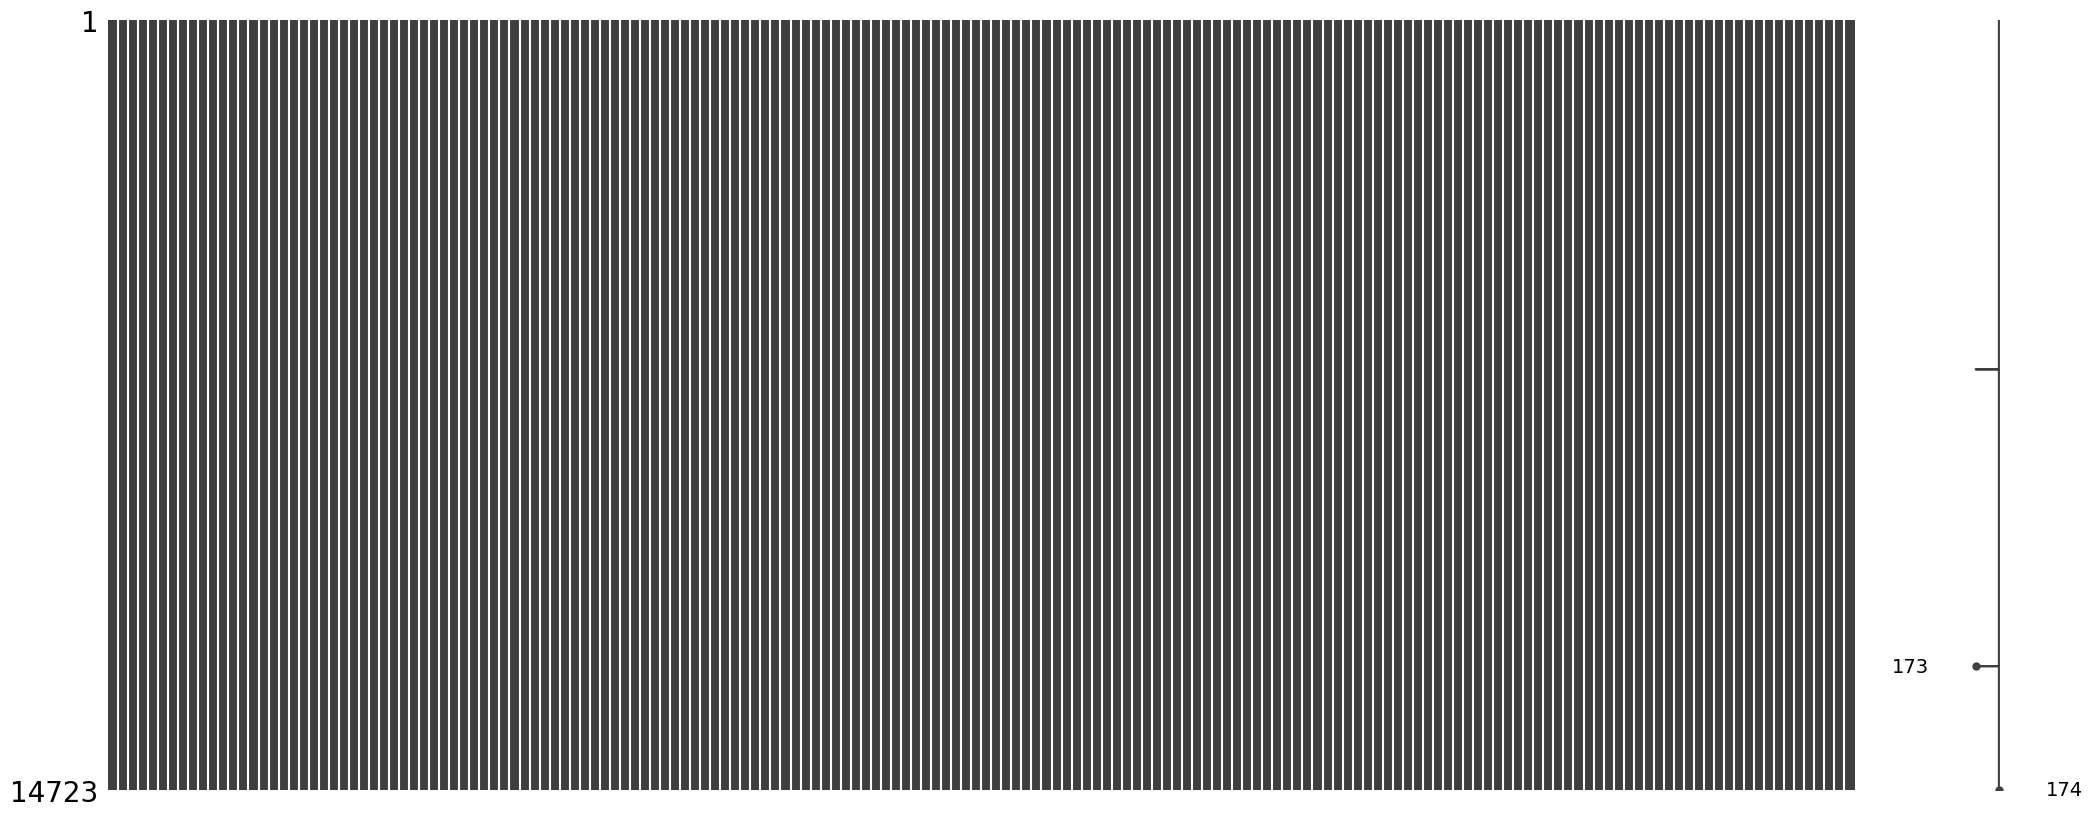

In [78]:
import missingno as msno
msno.matrix(data)

# no more na values

In [79]:
# categorical variables - for dummy coding
object_col.remove('numbedscategory') # has to be label-coded
object_col

['gender',
 'ethnicity',
 'hospitaladmitsource',
 'unittype',
 'unitadmitsource',
 'unitstaytype',
 'region']

In [80]:
print(data.shape)
dummy_col = [element for element in object_col]
data_subset = data[dummy_col]
data_encoded = pd.get_dummies(data_subset)
data_encoded = pd.concat([data.drop(columns=dummy_col), data_encoded], axis=1)
print(data_encoded.shape)
data_encoded.columns.to_list()

(14723, 174)
(14723, 220)


['patientunitstayid',
 'Class',
 'apachescore',
 'age',
 'admissionheight',
 'unitvisitnumber',
 'admissionweight',
 'numbedscategory',
 'teachingstatus',
 'history_AICD',
 'history_Angina',
 'history_Arrythmia',
 'history_CHF',
 'history_CABG',
 'history_Hypertension',
 'history_MI',
 'history_Pacemaker',
 'history_PVD',
 'history_PCI',
 'history_PulmEmb',
 'history_HeartTransp',
 'history_ValveDis',
 'history_VenThromb',
 'history_Cushing',
 'history_Hypercalcemia',
 'history_hyperthyroid',
 'history_hypothyroid',
 'history_diabetes',
 'history_Steroid Use',
 'history_Cirrhosis',
 'history_Hypersplenism',
 'history_PUD',
 'history_LiverTransp',
 'history_AplasticAnemia',
 'history_Chemotherapy',
 'history_RadiationTherapy',
 'history_Cancer',
 'history_ClottingDisorder',
 'history_HemolyticAnemia',
 'history_HypercoagulableCondition',
 'history_Oncology',
 'history_MyeloproliferativeDisease',
 'history_SickleCellDisease',
 'history_ImmuneSuppr',
 'history_Dementia',
 'history_Intracr

In [81]:
data_encoded.dtypes.value_counts()

bool       196
float64     14
object       7
int64        3
Name: count, dtype: int64

In [ ]:
# data_encoded['First24hrComa']=data_encoded['First24hrComa'].astype(int)
# data_encoded['first24hrs_vented']=data_encoded['first24hrs_vented'].astype(int)
# data_encoded['teachingstatus']=data_encoded['teachingstatus'].astype(int)
# data_encoded['urgentadmission']=data_encoded['urgentadmission'].astype(int)

In [82]:
# boolean values into numerical values (0/1)
data_f = data_encoded.astype(float)
data_f.reset_index(inplace=True)
data_f.drop('index', axis=1, inplace=True)

In [83]:
# Extract Labels Before Standardization
labels = data_f['Class']
data_f.drop(['Class'], axis=1, inplace=True)

# Standardize Data
data_standardized = data_f.iloc[:,1:]
scaler = preprocessing.StandardScaler()
data_standardized = scaler.fit_transform(data_standardized)

data_standardized = pd.DataFrame(data_standardized, columns=data_f.columns[1:])
data_standardized

,apachescore,age,admissionheight,unitvisitnumber,admissionweight,numbedscategory,teachingstatus,history_AICD,history_Angina,history_Arrythmia,...,unitadmitsource_Recovery Room,unitadmitsource_Step-Down Unit (SDU),unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer,region_Midwest,region_Northeast,region_South,region_West
0,0.783622,-1.110723,-0.753316,-0.340347,-1.120826,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018
1,0.825259,1.572835,-0.246621,-0.340347,-0.807795,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018
2,-2.464034,0.840956,0.936998,-0.340347,0.176941,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018
3,-1.006752,0.536006,0.260074,-0.340347,-0.146512,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018
4,3.698185,0.536006,-0.246621,-0.340347,0.000839,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,-0.090747,0.109076,0.431633,-0.340347,-0.559814,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018
14719,-0.465476,-0.805773,0.079207,1.564224,0.079905,-2.925814,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,-2.238166,-0.243015,-0.252131,4.319361,-0.537905,-0.155362,0.690135,-0.284018
14720,0.866895,-0.073894,-1.257352,-0.340347,-0.534657,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018
14721,-1.381482,-1.842603,-0.080382,-0.340347,-0.333396,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018


In [84]:
processed_data = pd.concat([data_standardized, labels], axis=1)
processed_data

,apachescore,age,admissionheight,unitvisitnumber,admissionweight,numbedscategory,teachingstatus,history_AICD,history_Angina,history_Arrythmia,...,unitadmitsource_Step-Down Unit (SDU),unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer,region_Midwest,region_Northeast,region_South,region_West,Class
0,0.783622,-1.110723,-0.753316,-0.340347,-1.120826,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018,1.0
1,0.825259,1.572835,-0.246621,-0.340347,-0.807795,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018,1.0
2,-2.464034,0.840956,0.936998,-0.340347,0.176941,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018,0.0
3,-1.006752,0.536006,0.260074,-0.340347,-0.146512,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018,0.0
4,3.698185,0.536006,-0.246621,-0.340347,0.000839,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,-0.090747,0.109076,0.431633,-0.340347,-0.559814,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018,1.0
14719,-0.465476,-0.805773,0.079207,1.564224,0.079905,-2.925814,-0.693999,0.0,0.0,0.0,...,-0.156049,-2.238166,-0.243015,-0.252131,4.319361,-0.537905,-0.155362,0.690135,-0.284018,1.0
14720,0.866895,-0.073894,-1.257352,-0.340347,-0.534657,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018,1.0
14721,-1.381482,-1.842603,-0.080382,-0.340347,-0.333396,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018,1.0


In [86]:
# save off the df
processed_data.to_csv(modelling_path+"processed_df_dynamic.csv", index=False)
# check if successfuly saved
processed_data = pd.read_csv(modelling_path+"processed_df_dynamic.csv")
processed_data

,apachescore,age,admissionheight,unitvisitnumber,admissionweight,numbedscategory,teachingstatus,history_AICD,history_Angina,history_Arrythmia,...,unitadmitsource_Step-Down Unit (SDU),unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer,region_Midwest,region_Northeast,region_South,region_West,Class
0,0.783622,-1.110723,-0.753316,-0.340347,-1.120826,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018,1.0
1,0.825259,1.572835,-0.246621,-0.340347,-0.807795,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018,1.0
2,-2.464034,0.840956,0.936998,-0.340347,0.176941,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018,0.0
3,-1.006752,0.536006,0.260074,-0.340347,-0.146512,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018,0.0
4,3.698185,0.536006,-0.246621,-0.340347,0.000839,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,-0.090747,0.109076,0.431633,-0.340347,-0.559814,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018,1.0
14719,-0.465476,-0.805773,0.079207,1.564224,0.079905,-2.925814,-0.693999,0.0,0.0,0.0,...,-0.156049,-2.238166,-0.243015,-0.252131,4.319361,-0.537905,-0.155362,0.690135,-0.284018,1.0
14720,0.866895,-0.073894,-1.257352,-0.340347,-0.534657,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018,1.0
14721,-1.381482,-1.842603,-0.080382,-0.340347,-0.333396,0.341785,-0.693999,0.0,0.0,0.0,...,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018,1.0


## 3. Classification

In [88]:
processed_data = pd.read_csv(modelling_path+"processed_df_dynamic.csv")
labels = processed_data.Class
dataset = processed_data.iloc[:,:-1]
dataset

,apachescore,age,admissionheight,unitvisitnumber,admissionweight,numbedscategory,teachingstatus,history_AICD,history_Angina,history_Arrythmia,...,unitadmitsource_Recovery Room,unitadmitsource_Step-Down Unit (SDU),unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer,region_Midwest,region_Northeast,region_South,region_West
0,0.783622,-1.110723,-0.753316,-0.340347,-1.120826,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018
1,0.825259,1.572835,-0.246621,-0.340347,-0.807795,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018
2,-2.464034,0.840956,0.936998,-0.340347,0.176941,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018
3,-1.006752,0.536006,0.260074,-0.340347,-0.146512,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018
4,3.698185,0.536006,-0.246621,-0.340347,0.000839,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,1.859063,-0.155362,-1.448992,-0.284018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,-0.090747,0.109076,0.431633,-0.340347,-0.559814,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018
14719,-0.465476,-0.805773,0.079207,1.564224,0.079905,-2.925814,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,-2.238166,-0.243015,-0.252131,4.319361,-0.537905,-0.155362,0.690135,-0.284018
14720,0.866895,-0.073894,-1.257352,-0.340347,-0.534657,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018
14721,-1.381482,-1.842603,-0.080382,-0.340347,-0.333396,0.341785,-0.693999,0.0,0.0,0.0,...,-0.232329,-0.156049,0.446794,-0.243015,-0.252131,-0.231516,-0.537905,-0.155362,0.690135,-0.284018


In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import t

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, stratify=labels, random_state=42)

In [91]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11778, 218) (11778,)
(2945, 218) (2945,)


In [93]:
# stratified split - label outcome variable distribution
print(y_train.value_counts()/y_train.shape[0])
print('\n')
print(y_test.value_counts()/y_test.shape[0])

Class
0.0    0.848276
1.0    0.151724
Name: count, dtype: float64


Class
0.0    0.848217
1.0    0.151783
Name: count, dtype: float64


In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import t
from sklearn.metrics import confusion_matrix


def train_and_evaluate(X_train, y_train, clf, cv):
    precision_scores = []
    recall_scores = []
    roc_auc_scores = []
    brier_scores = []
    specificity_list = []
    sensitivity_list = []
    npv_list = []
    ppv_list = []
    precision_list = []
    recall_list = []
    fpr_list = []  # List to store false positive rates
    tpr_list = []  # List to store true positive rates

    for train_index, val_index in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        clf.fit(X_train_fold, y_train_fold)
        y_pred_proba = clf.predict_proba(X_val_fold)[:, 1]

        precision, recall, _ = precision_recall_curve(y_val_fold, y_pred_proba)
        precision_scores.append(precision)
        recall_scores.append(recall)

        roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred_proba))
        brier_scores.append(brier_score_loss(y_val_fold, y_pred_proba))

        y_pred = clf.predict(X_val_fold)

        tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred).ravel()

        precision = precision_score(y_val_fold, y_pred)
        precision_list.append(precision)
        recall = recall_score(y_val_fold, y_pred)
        recall_list.append(recall)

        specificity = tn / (tn + fp)
        specificity_list.append(specificity)

        sensitivity = tp / (tp + fn)
        sensitivity_list.append(sensitivity)

        npv = tn / (tn + fn)
        npv_list.append(npv)

        ppv = tp / (tp + fp)
        ppv_list.append(ppv)

        # Calculate fpr and tpr
        fpr, tpr, _ = roc_curve(y_val_fold, y_pred_proba)
        fpr_list.append(fpr)
        tpr_list.append(tpr)

    return precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list

def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    t_value = t.ppf((1 + confidence) / 2, n - 1)
    margin_of_error = t_value * std_err
    return mean, margin_of_error

def plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc'):
    plt.figure()
    if curve_type == 'precision_recall':
        for i in range(len(precision_scores)):
            plt.plot(recall_scores[i], precision_scores[i], lw=1, alpha=0.3, label='Fold %d' % i)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="best")
    elif curve_type == 'roc':
        for i in range(len(fpr_list)):
            plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='Fold %d' % i)

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
    plt.show()


def print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list):
    mean_roc_auc, roc_auc_ci = calculate_confidence_interval(roc_auc_scores)
    mean_brier_score, brier_score_ci = calculate_confidence_interval(brier_scores)
    specificity_mean, specificity_ci = calculate_confidence_interval(specificity_list)
    sensitivity_mean, sensitivity_ci = calculate_confidence_interval(sensitivity_list)
    npv_mean, npv_ci = calculate_confidence_interval(npv_list)
    ppv_mean, ppv_ci = calculate_confidence_interval(ppv_list)
    precision_mean, precision_ci = calculate_confidence_interval(precision_list)
    recall_mean, recall_ci = calculate_confidence_interval(recall_list)

    print("ROC AUC Score:", round(mean_roc_auc,3), (round((mean_roc_auc - roc_auc_ci),3), round((mean_roc_auc + roc_auc_ci),3)))
    print("Brier Score:", round(mean_brier_score,3), (round((mean_brier_score - brier_score_ci),3), round((mean_brier_score + brier_score_ci),3)))
    print("Specificity: {:.3f} ({:.3f}, {:.3f})".format(specificity_mean, specificity_mean - specificity_ci, specificity_mean + specificity_ci))
    print("Sensitivity: {:.3f} ({:.3f}, {:.3f})".format(sensitivity_mean, sensitivity_mean - sensitivity_ci, sensitivity_mean + sensitivity_ci))
    print("Negative Predictive Value (NPV): {:.3f} ({:.3f}, {:.3f})".format(npv_mean, npv_mean - npv_ci, npv_mean + npv_ci))
    print("Positive Predictive Value (PPV): {:.3f} ({:.3f}, {:.3f})".format(ppv_mean, ppv_mean - ppv_ci, ppv_mean + ppv_ci))
    print("Precision: {:.3f} ({:.3f}, {:.3f})".format(precision_mean, precision_mean - specificity_ci, precision_mean + precision_ci))
    print("Recall: {:.3f} ({:.3f}, {:.3f})".format(recall_mean, recall_mean - sensitivity_ci, recall_mean + recall_ci))


def evaluate_test_set(clf, X_test, y_test):
    y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
    y_pred_test = clf.predict(X_test)

    recall_test = recall_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
    brier_score_test = brier_score_loss(y_test, y_pred_proba_test)

    print("Test Set Metrics:")
    print("ROC AUC Score:", round(roc_auc_test, 3))
    print("Recall (Sensitivity):", round(recall_test, 3))
    print("Brier Score:", round(brier_score_test, 3))

### Random Forest

ROC AUC Score: 0.771 (0.751, 0.79)
Brier Score: 0.11 (0.108, 0.112)
Specificity: 0.993 (0.990, 0.995)
Sensitivity: 0.086 (0.073, 0.098)
Negative Predictive Value (NPV): 0.859 (0.857, 0.860)
Positive Predictive Value (PPV): 0.680 (0.619, 0.742)
Precision: 0.680 (0.678, 0.742)
Recall: 0.086 (0.073, 0.098)


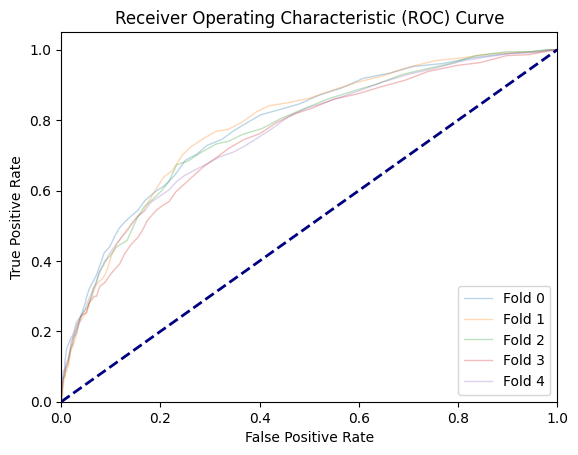

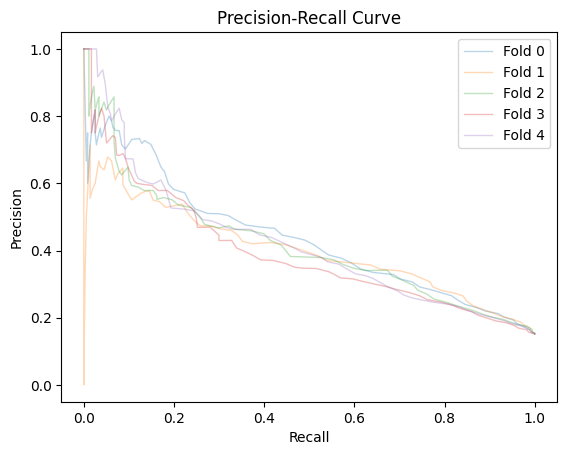

In [95]:
# Initializing the classifier
clf = RandomForestClassifier()

# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train, y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

In [96]:
evaluate_test_set(clf, X_test, y_test)

Test Set Metrics:
ROC AUC Score: 0.786
Recall (Sensitivity): 0.116
Brier Score: 0.107


### Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

ROC AUC Score: 0.747 (0.731, 0.763)
Brier Score: 0.114 (0.11, 0.118)
Specificity: 0.976 (0.969, 0.983)
Sensitivity: 0.146 (0.125, 0.167)
Negative Predictive Value (NPV): 0.865 (0.862, 0.868)
Positive Predictive Value (PPV): 0.528 (0.441, 0.614)
Precision: 0.528 (0.521, 0.614)
Recall: 0.146 (0.125, 0.167)


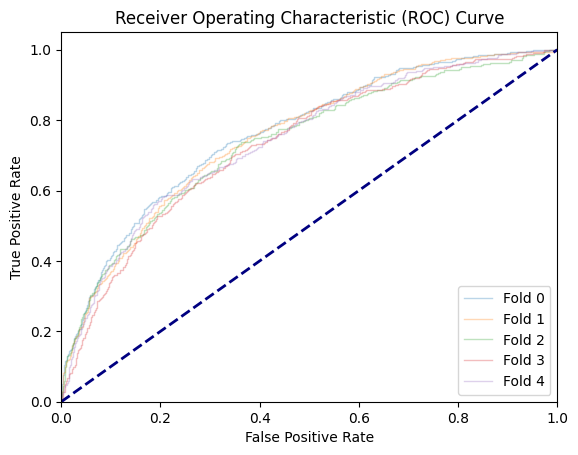

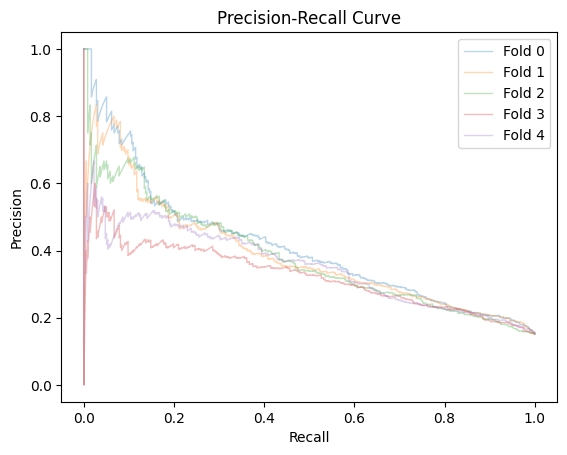

In [97]:
from sklearn.linear_model import LogisticRegression

# Initializing the classifier
clf = LogisticRegression()

# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train, y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

In [98]:
evaluate_test_set(clf, X_test, y_test)

Test Set Metrics:
ROC AUC Score: 0.764
Recall (Sensitivity): 0.177
Brier Score: 0.111


### Catboost

In [99]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.2 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
12:	learn: 0.5222781	total: 180ms	remaining: 13.7s
13:	learn: 0.5139707	total: 190ms	remaining: 13.4s
14:	learn: 0.5060042	total: 202ms	remaining: 13.3s
15:	learn: 0.4987665	total: 212ms	remaining: 13s
16:	learn: 0.4911708	total: 221ms	remaining: 12.8s
17:	learn: 0.4847620	total: 230ms	remaining: 12.6s
18:	learn: 0.4790127	total: 239ms	remaining: 12.4s
19:	learn: 0.4737014	total: 248ms	remaining: 12.2s
20:	learn: 0.4679933	total: 258ms	remaining: 12s
21:	learn: 0.4629143	total: 266ms	remaining: 11.8s
22:	learn: 0.4580390	total: 276ms	remaining: 11.7s
23:	learn: 0.4533891	total: 285ms	remaining: 11.6s
24:	learn: 0.4490804	total: 296ms	remaining: 11.5s
25:	learn: 0.4445102	total: 305ms	remaining: 11.4s
26:	learn: 0.4406509	total: 314ms	remaining: 11.3s
27:	learn: 0.4372320	total: 323ms	remaining: 11.2s
28:	learn: 0.4337526	total: 332ms	remaining: 11.1s
29:	learn: 0.4302493	total: 342ms	remaining: 11.1s
30:	learn: 0.4256996	total: 351ms	r

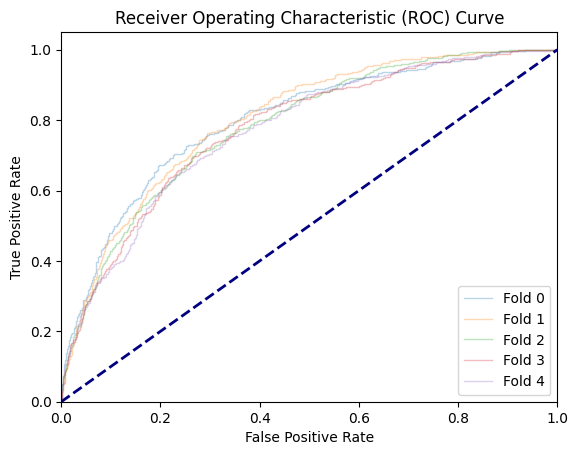

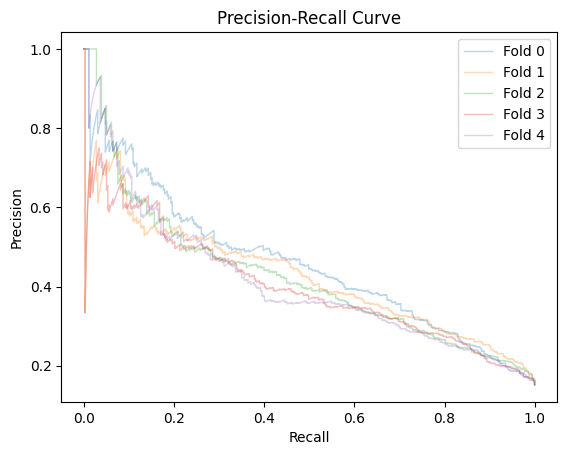

In [100]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier()

# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train, y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

In [101]:
evaluate_test_set(clf, X_test, y_test)

Test Set Metrics:
ROC AUC Score: 0.806
Recall (Sensitivity): 0.166
Brier Score: 0.106


### XGBoost

In [102]:
pip install xgboost

ROC AUC Score: 0.751 (0.738, 0.765)
Brier Score: 0.118 (0.115, 0.121)
Specificity: 0.962 (0.954, 0.970)
Sensitivity: 0.199 (0.177, 0.221)
Negative Predictive Value (NPV): 0.870 (0.868, 0.873)
Positive Predictive Value (PPV): 0.486 (0.450, 0.522)
Precision: 0.486 (0.478, 0.522)
Recall: 0.199 (0.177, 0.221)


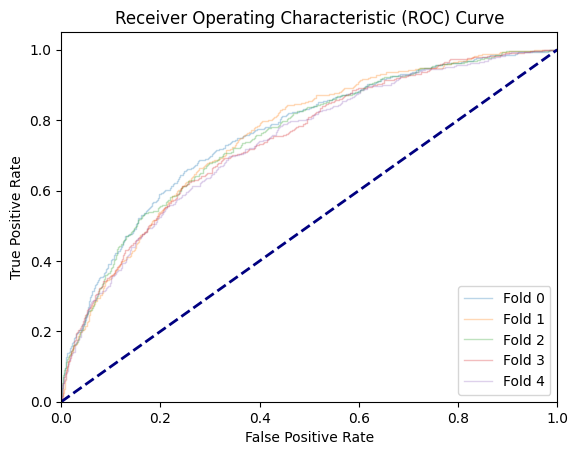

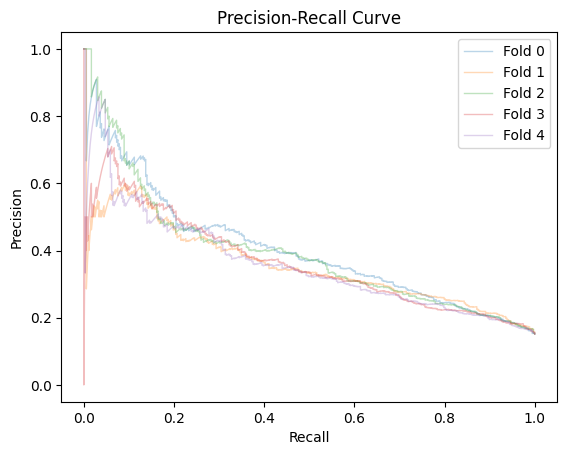

Test Set Metrics:
ROC AUC Score: 0.765
Recall (Sensitivity): 0.215
Brier Score: 0.118


In [103]:
# Initializing the classifier
from xgboost import XGBClassifier
clf = XGBClassifier()

# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train, y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

evaluate_test_set(clf, X_test, y_test)

#### XGBoost + decision boundary tuning

In [104]:
# Confusion matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    title_first_line = title
    tp_fn_sum = np.sum(np.diag(cm)) + np.sum(cm[:, -1])
    title_second_line = f"TP+FN: {tp_fn_sum}"
    title_fontsize_first_line = 12
    title_fontsize_second_line = 8

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title_first_line + '\n' + title_second_line, fontsize=title_fontsize_first_line)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Calculate and print sum of TP and FN
    # tp_fn_sum = np.sum(np.diag(cm)) + np.sum(cm[:, -1])
    # plt.text(-0.5, -0.5, f"TP+FN: {tp_fn_sum}", horizontalalignment="left", verticalalignment="center", color="red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Decision boundary Tuning
thresholds = [0.35,0.38,0.41,0.44,0.47,0.50,0.53,0.56,0.59]
def decision_bnd_tuning(model, thresholds, X_valid, y_valid):
  y_pred_proba = model.predict_proba(X_valid)

  plt.figure(figsize=(10,10))
  j = 1
  for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] > i

    plt.subplot(3,3,j)
    j += 1
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_valid,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    Recall = round(cnf_matrix[1,1] / (cnf_matrix[1,1] + cnf_matrix[1,0]),4)
    Precision = round(cnf_matrix[1,1] / (cnf_matrix[1,1] + cnf_matrix[0,1]),4)
    Accuracy = round((cnf_matrix[1,1] + cnf_matrix[0,0]) / (cnf_matrix[1,1] + cnf_matrix[1,0] + cnf_matrix[0,1] + cnf_matrix[0,0]),4)
    F1 = round((2*Recall*Precision/(Recall+Precision)),4)
    print("<threshold ",i,">")
    print("Accuracy: ", Accuracy, "| F1: ", F1, "| Recall: ", Recall, "| Precision: ", Precision)

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i)


<threshold  0.35 >
Accuracy:  0.9581 | F1:  0.8567 | Recall:  0.8248 | Precision:  0.8912
<threshold  0.38 >
Accuracy:  0.9584 | F1:  0.8555 | Recall:  0.812 | Precision:  0.904
<threshold  0.41 >
Accuracy:  0.9589 | F1:  0.8555 | Recall:  0.8019 | Precision:  0.9168
<threshold  0.44 >
Accuracy:  0.9574 | F1:  0.848 | Recall:  0.7834 | Precision:  0.9241
<threshold  0.47 >
Accuracy:  0.9556 | F1:  0.8396 | Recall:  0.7661 | Precision:  0.9288
<threshold  0.5 >
Accuracy:  0.954 | F1:  0.8313 | Recall:  0.7476 | Precision:  0.9362
<threshold  0.53 >
Accuracy:  0.952 | F1:  0.8217 | Recall:  0.7286 | Precision:  0.9421
<threshold  0.56 >
Accuracy:  0.9495 | F1:  0.8096 | Recall:  0.7079 | Precision:  0.9454
<threshold  0.59 >
Accuracy:  0.9461 | F1:  0.7931 | Recall:  0.681 | Precision:  0.9493


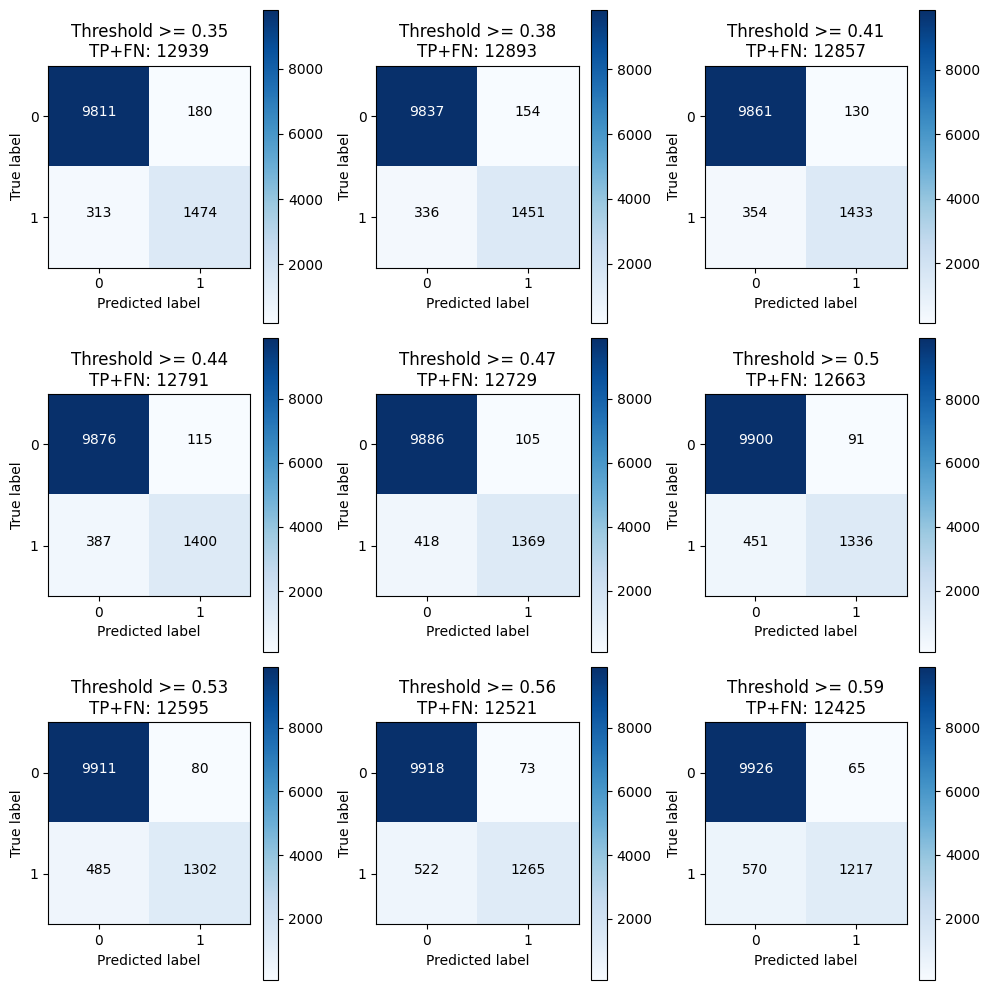

In [105]:
# train set
decision_bnd_tuning(clf, thresholds, X_train, y_train)

<threshold  0.35 >
Accuracy:  0.8323 | F1:  0.3568 | Recall:  0.3065 | Precision:  0.4268
<threshold  0.38 >
Accuracy:  0.839 | F1:  0.356 | Recall:  0.2931 | Precision:  0.4533
<threshold  0.41 >
Accuracy:  0.8448 | F1:  0.3554 | Recall:  0.2819 | Precision:  0.4809
<threshold  0.44 >
Accuracy:  0.8492 | F1:  0.3451 | Recall:  0.2617 | Precision:  0.5065
<threshold  0.47 >
Accuracy:  0.8482 | F1:  0.3176 | Recall:  0.2327 | Precision:  0.5
<threshold  0.5 >
Accuracy:  0.8482 | F1:  0.3005 | Recall:  0.2148 | Precision:  0.5
<threshold  0.53 >
Accuracy:  0.8496 | F1:  0.2844 | Recall:  0.1969 | Precision:  0.5116
<threshold  0.56 >
Accuracy:  0.8499 | F1:  0.2658 | Recall:  0.179 | Precision:  0.5161
<threshold  0.59 >
Accuracy:  0.8499 | F1:  0.2353 | Recall:  0.1521 | Precision:  0.5191


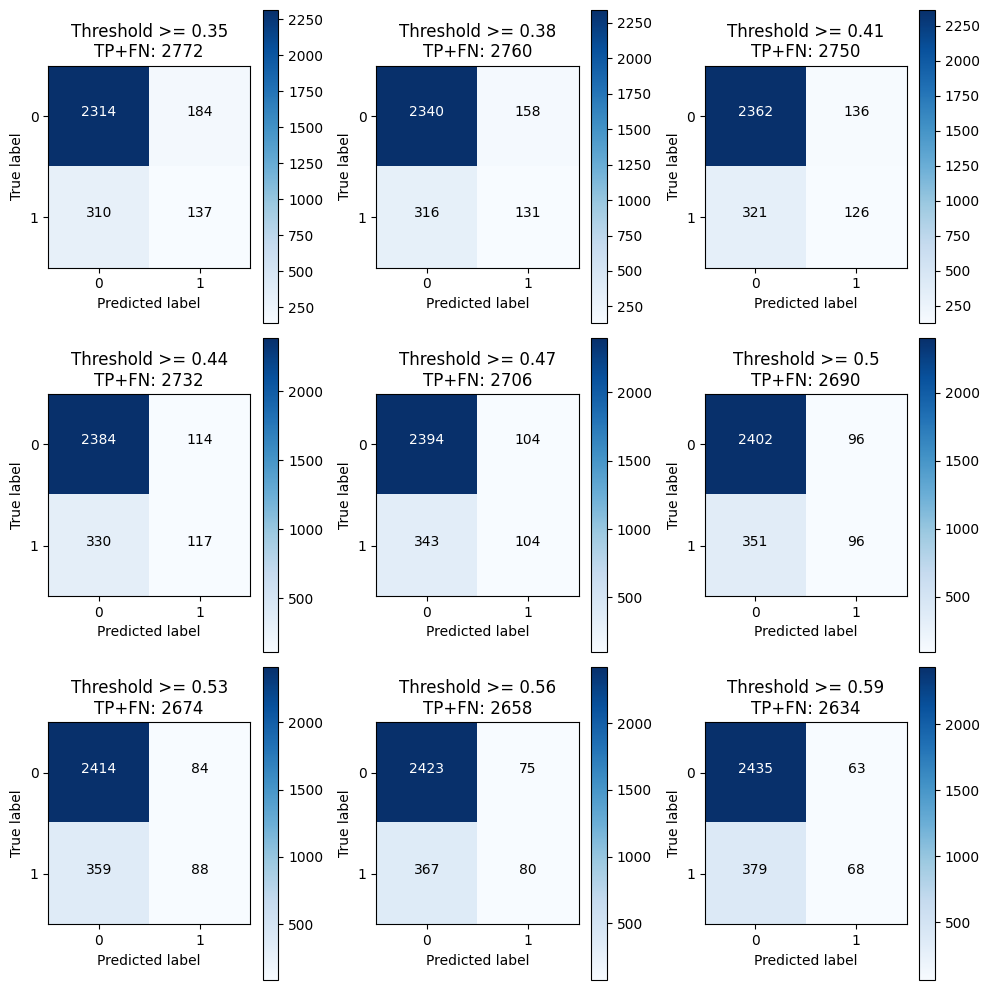

In [106]:
# validation set
decision_bnd_tuning(clf, thresholds, X_test, y_test)

#### XGBoost + hyperparameter tuning

In [109]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


xgb = XGBClassifier()
grid = {'max_depth': [2,3,4],'n_estimators':[300],'learning_rate':[0.25, 0.3, 0.35]}

#Instantiate GridSearchCV
gscv = GridSearchCV (estimator = xgb, param_grid = grid, scoring ='recall_macro', cv = 4)

#fit the model
gscv.fit(X_train, y_train)

#returns the estimator with the best performance
print(gscv.best_estimator_)

#returns the best score
print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.5950339954223477
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}


- varied the parameters with other values many times

ROC AUC Score: 0.751 (0.738, 0.765)
Brier Score: 0.118 (0.115, 0.121)
Specificity: 0.962 (0.954, 0.970)
Sensitivity: 0.199 (0.177, 0.221)
Negative Predictive Value (NPV): 0.870 (0.868, 0.873)
Positive Predictive Value (PPV): 0.486 (0.450, 0.522)
Precision: 0.486 (0.478, 0.522)
Recall: 0.199 (0.177, 0.221)


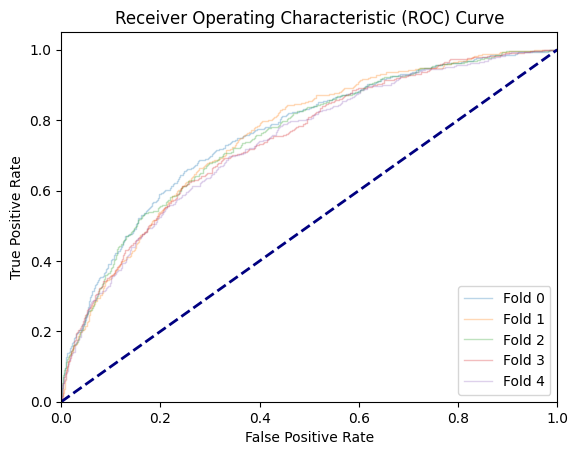

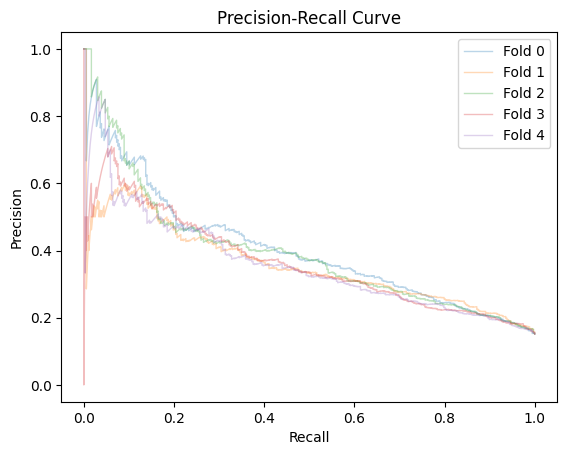

Test Set Metrics:
ROC AUC Score: 0.765
Recall (Sensitivity): 0.215
Brier Score: 0.118


In [110]:
params = {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}
xgb_tuned = XGBClassifier(**params)

# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train, y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

evaluate_test_set(clf, X_test, y_test)

- the train/validation set performance is same

<threshold  0.35 >
Accuracy:  0.8422 | F1:  0.6335 | Recall:  0.6301 | Precision:  0.6369
<threshold  0.38 >
Accuracy:  0.8439 | F1:  0.6261 | Recall:  0.6039 | Precision:  0.6499
<threshold  0.41 >
Accuracy:  0.8472 | F1:  0.6247 | Recall:  0.5874 | Precision:  0.667
<threshold  0.44 >
Accuracy:  0.8508 | F1:  0.6232 | Recall:  0.5699 | Precision:  0.6874
<threshold  0.47 >
Accuracy:  0.8561 | F1:  0.6259 | Recall:  0.5563 | Precision:  0.7154
<threshold  0.5 >
Accuracy:  0.8565 | F1:  0.6199 | Recall:  0.5408 | Precision:  0.7262
<threshold  0.53 >
Accuracy:  0.8577 | F1:  0.6151 | Recall:  0.5252 | Precision:  0.7421
<threshold  0.56 >
Accuracy:  0.858 | F1:  0.6061 | Recall:  0.5049 | Precision:  0.758
<threshold  0.59 >
Accuracy:  0.8582 | F1:  0.5961 | Recall:  0.4835 | Precision:  0.7769


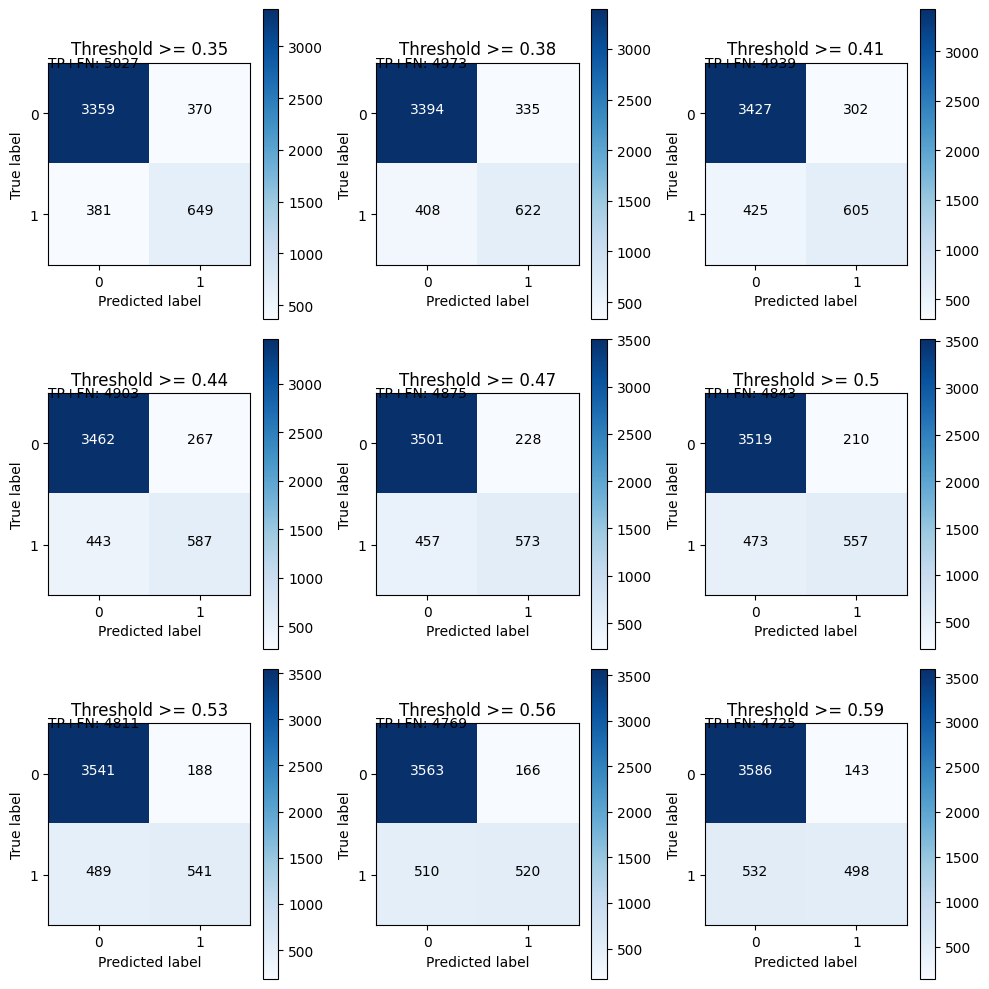

In [ ]:
decision_bnd_tuning(clf, thresholds, X_test, y_test)

### (+a) Feature Selection

In [111]:
import seaborn as sns

def get_importances (model, X_train, y_train):
  model.fit(X_train, y_train)
  ftr_importances = model.feature_importances_
  ftr_importances = pd.Series(ftr_importances, index = X_train.columns)
  ftr_imp = ftr_importances.sort_values(ascending=False)[:70]

  plt.figure(figsize=(10,20))
  plt.title('Feature Importances')
  sns.barplot(x=ftr_imp, y=ftr_imp.index)
  plt.show()

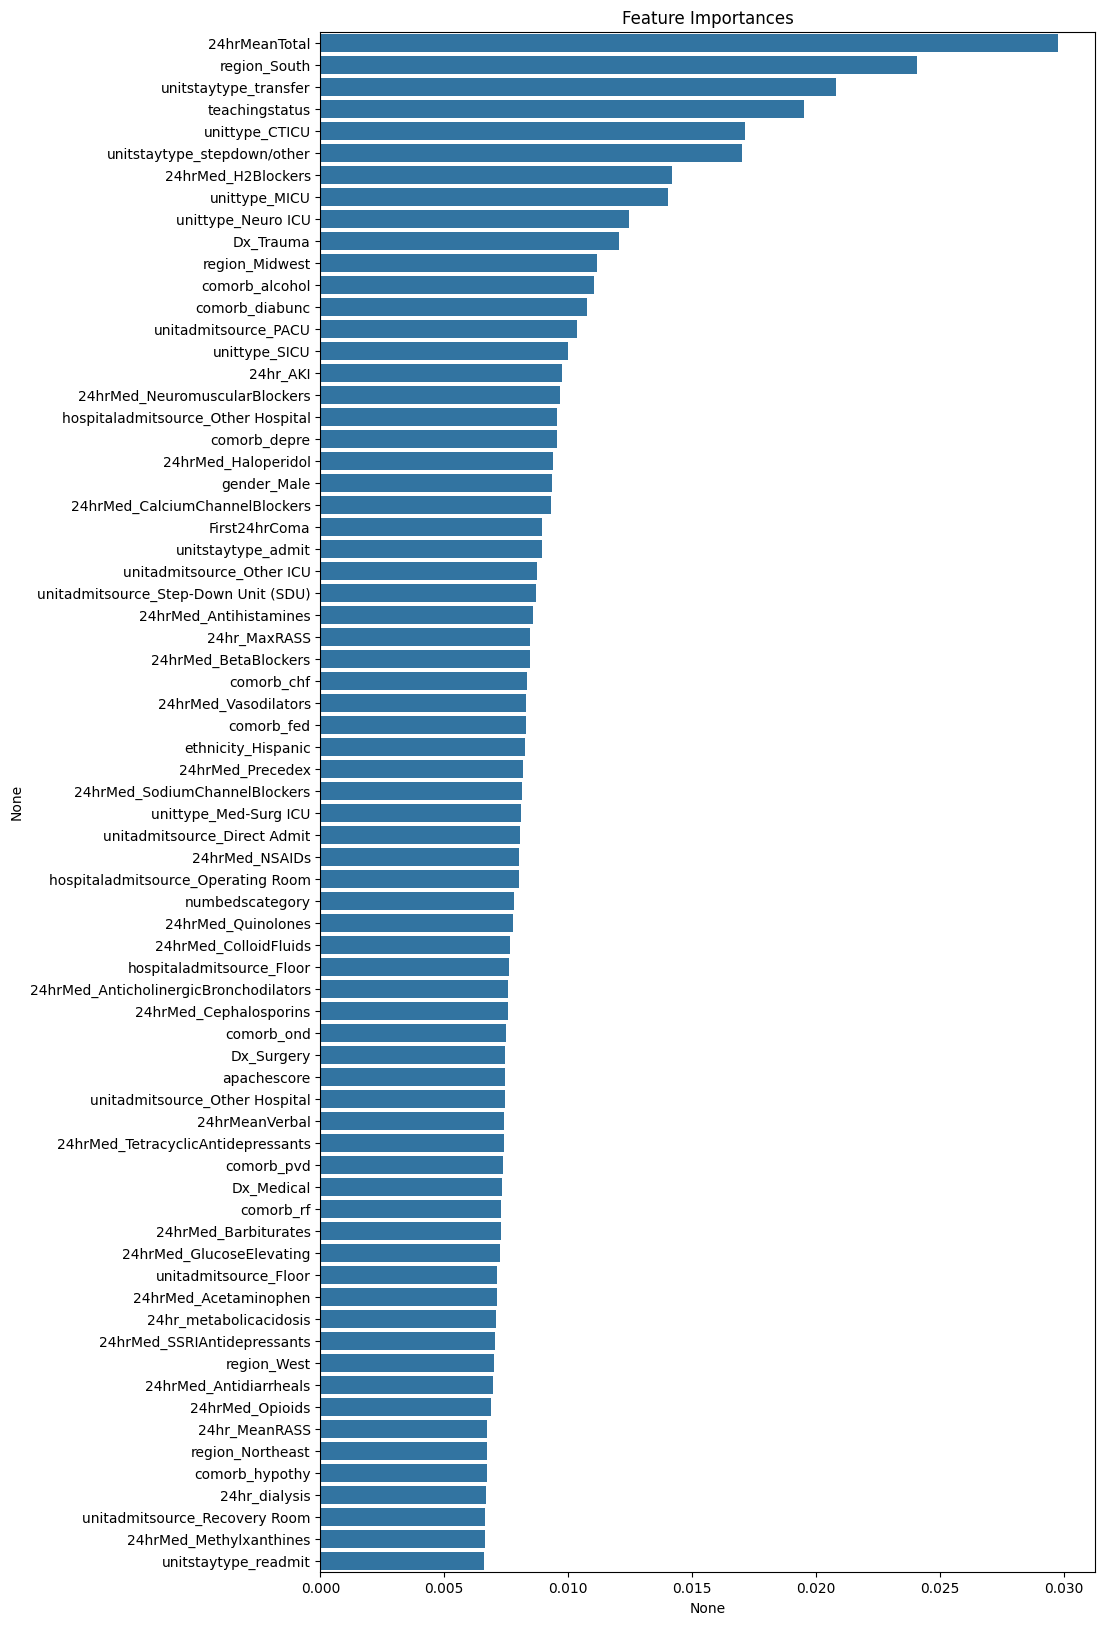

In [112]:
get_importances(clf, X_train, y_train)

In [ ]:
ftr_importances = xgb_tuned.feature_importances_
ftr_importances = pd.Series(ftr_importances, index = X_train.columns)
ftr_imp = ftr_importances.sort_values(ascending=False)
feature_selection = ftr_imp[ftr_imp>0].index.to_list()

ROC AUC Score: 0.771 (0.764, 0.778)
Brier Score: 0.142 (0.14, 0.144)
Specificity: 0.936 (0.932, 0.940)
Sensitivity: 0.325 (0.316, 0.334)
Negative Predictive Value (NPV): 0.834 (0.832, 0.835)
Positive Predictive Value (PPV): 0.583 (0.571, 0.594)
Precision: 0.583 (0.579, 0.594)
Recall: 0.325 (0.316, 0.334)


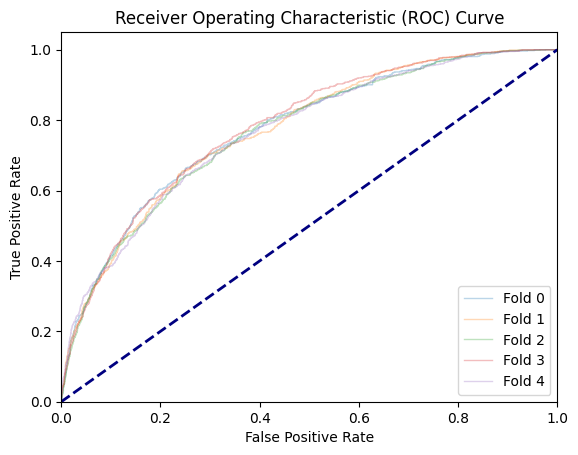

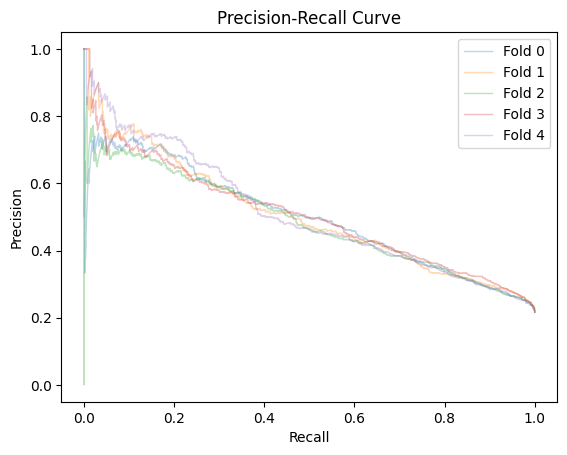

Test Set Metrics:
ROC AUC Score: 0.77
Recall (Sensitivity): 0.318
Brier Score: 0.146


In [ ]:
# Performing cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation only with selected columns
precision_scores, recall_scores, roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list, fpr_list, tpr_list = train_and_evaluate(X_train[feature_selection], y_train, clf, cv)

# Print metrics with confidence intervals
print_metrics_with_ci(roc_auc_scores, brier_scores, specificity_list, sensitivity_list, npv_list, ppv_list, precision_list, recall_list)

# Plot ROC curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='roc')

# Plot Precision-Recall curve
plot_curve(precision_scores, recall_scores, fpr_list, tpr_list, curve_type='precision_recall')

evaluate_test_set(clf, X_test[feature_selection], y_test)

- doesn't show the improvement